# CAFA 5

## Importing Libraries

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import obonet
import networkx
import time
import os
import warnings
import pickle
import copy
import re

# Importing plotting libraries
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# Importing BioPython for biological sequence handling
from Bio import SeqIO

# Importing tqdm for progress bars
from tqdm import tqdm

# Importing functools for functional programming tools
from functools import reduce

# Importing TensorFlow for machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

# Importing evaluation metrics and data preprocessing from sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Importing specific module from TensorFlow
from tensorflow import keras

from scipy.stats import spearmanr

# Suppressing warning messages
warnings.filterwarnings('ignore')

# Loading and Processing Training Data

## Opening train_terms

In [2]:
train_terms = pd.read_csv('Train/train_terms.tsv', sep='\t')
print(train_terms.info())
train_terms.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363863 entries, 0 to 5363862
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   EntryID  object
 1   term     object
 2   aspect   object
dtypes: object(3)
memory usage: 122.8+ MB
None


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


The terms CCO, BPO and MFO were separeted into columns using Boolean to facilitate the visualization of the division and reduce, with True and False, the use of memory.

In [3]:
train_terms['BPO'] = train_terms['aspect'].apply(lambda x: True if x=='BPO' else False)
train_terms['CCO'] = train_terms['aspect'].apply(lambda x: True if x=='CCO' else False)
train_terms['MFO'] = train_terms['aspect'].apply(lambda x: True if x=='MFO' else False)
train_terms.drop('aspect', axis=1, inplace=True)

print(train_terms.info())
train_terms.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363863 entries, 0 to 5363862
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   EntryID  object
 1   term     object
 2   BPO      bool  
 3   CCO      bool  
 4   MFO      bool  
dtypes: bool(3), object(2)
memory usage: 97.2+ MB
None


,EntryID,term,BPO,CCO,MFO
0,A0A009IHW8,GO:0008152,True,False,False
1,A0A009IHW8,GO:0034655,True,False,False
2,A0A009IHW8,GO:0072523,True,False,False
3,A0A009IHW8,GO:0044270,True,False,False
4,A0A009IHW8,GO:0006753,True,False,False


In [4]:
print(f'BPO: {train_terms["BPO"].sum():>9,} -> {train_terms["BPO"].sum()/train_terms.shape[0]*100:.2f}%')
print(f'CCO: {train_terms["CCO"].sum():>9,} -> {train_terms["CCO"].sum()/train_terms.shape[0]*100:.2f}%')
print(f'MFO: {train_terms["MFO"].sum():>9,} -> {train_terms["MFO"].sum()/train_terms.shape[0]*100:.2f}%')

BPO: 3,497,732 -> 65.21%
CCO: 1,196,017 -> 22.30%
MFO:   670,114 -> 12.49%


## Creating a Venn Chart with train_terms

Lets disregard the terms to learn about their relationship with cellular components (CCO), function (MFO) and process (BPO)

In [5]:
prot_func = train_terms.drop('term', axis=1)
prot_func = prot_func.drop_duplicates(subset=['EntryID', 'BPO', 'CCO', 'MFO'], ignore_index=True)
prot_func.head()

,EntryID,BPO,CCO,MFO
0,A0A009IHW8,True,False,False
1,A0A021WW32,True,False,False
2,A0A023FFD0,True,False,False
3,A0A023GPJ3,True,False,False
4,A0A023GPK8,True,False,False


In [6]:
print(f'BPO: {prot_func["BPO"].sum():>9,} -> {prot_func["BPO"].sum()/prot_func.shape[0]*100:.2f}%')
print(f'CCO: {prot_func["CCO"].sum():>9,} -> {prot_func["CCO"].sum()/prot_func.shape[0]*100:.2f}%')
print(f'MFO: {prot_func["MFO"].sum():>9,} -> {prot_func["MFO"].sum()/prot_func.shape[0]*100:.2f}%')
print(f'Total Protein: {prot_func.shape[0]:,}')

BPO:    92,210 -> 34.96%
CCO:    92,912 -> 35.23%
MFO:    78,637 -> 29.81%
Total Protein: 263,759


In [7]:
def reduce_prot_func(df):
    """
    Reduces a DataFrame containing protein functional annotations by grouping entries based on 'EntryID'
    and aggregating functional categories.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing protein functional annotations.
        It should have columns 'EntryID', 'BPO', 'CCO', and 'MFO' representing Entry ID, Biological Process (BPO),
        Cellular Component (CCO), and Molecular Function (MFO) categories respectively.

    Returns:
    pandas.DataFrame: A new DataFrame with reduced functional annotations.
        Each unique 'EntryID' is grouped, and within each group, the 'BPO', 'CCO', and 'MFO' columns are aggregated
        using the 'any' function to check if any True value exists in the group. The resulting DataFrame has a row for
        each unique 'EntryID' with consolidated functional annotation information.

    Example:
    >>> data = {'EntryID': ['A', 'A', 'B', 'B'],
    ...         'BPO': [True, False, False, True],
    ...         'CCO': [False, True, True, False],
    ...         'MFO': [True, False, True, False]}
    >>> df = pd.DataFrame(data)
    >>> reduced_df = reduce_prot_func(df)
    >>> print(reduced_df)
      EntryID    BPO    CCO    MFO
    0       A   True   True   True
    1       B   True   True   True
    """
        
    grouped = df.groupby('EntryID').agg({'BPO': 'any', 'CCO': 'any', 'MFO': 'any'}).reset_index()
    return grouped

In [8]:
prot_func = reduce_prot_func(prot_func)
print(prot_func.info())
prot_func.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   EntryID  142246 non-null  object
 1   BPO      142246 non-null  bool  
 2   CCO      142246 non-null  bool  
 3   MFO      142246 non-null  bool  
dtypes: bool(3), object(1)
memory usage: 1.5+ MB
None


,EntryID,BPO,CCO,MFO
0,A0A009IHW8,True,False,True
1,A0A021WW32,True,True,False
2,A0A021WZA4,False,True,False
3,A0A023FBW4,False,False,True
4,A0A023FBW7,False,False,True
5,A0A023FDY8,False,False,True
6,A0A023FF81,False,False,True
7,A0A023FFB5,False,False,True
8,A0A023FFD0,True,False,True
9,A0A023FT45,False,False,True


## Filtering the Data and Separating into Variables

Analyzing the data it was detected that a function has several functions that are in different groups, not being exclusive BPO or MFO, but being able to belong to two groups and even to three.

Functions are included in only one of the groups, but the proteins, on which functions depend, are related in a more complex way.

The Venn diagram can demonstrate more clearly the relationship of proteins with the groups where the functions are found.

In [9]:
bpo_cco = prot_func.loc[(prot_func['BPO']==True) & (prot_func['CCO']==True)]
bpo_mfo = prot_func.loc[(prot_func['BPO']==True) & (prot_func['MFO']==True)]
cco_mfo = prot_func.loc[(prot_func['CCO']==True) & (prot_func['MFO']==True)]
bpo_cco_mfo = prot_func.loc[(prot_func['BPO']==True) & (prot_func['CCO']==True) & (prot_func['MFO']==True)]

unique_bpo = prot_func.loc[(prot_func['BPO']==True) & (prot_func['CCO']==False) & (prot_func['MFO']==False)]
unique_cco = prot_func.loc[(prot_func['BPO']==False) & (prot_func['CCO']==True) & (prot_func['MFO']==False)]
unique_mfo = prot_func.loc[(prot_func['BPO']==False) & (prot_func['CCO']==False) & (prot_func['MFO']==True)]

In [10]:
print(f'ITEM {" "*18}VALUES')
print(f'BPO total: {prot_func["BPO"].sum():>18,}')
print(f'CCO total: {prot_func["CCO"].sum():>18,}')
print(f'MFO total: {prot_func["MFO"].sum():>18,}')
print(f'ROWS: {prot_func.shape[0]:>23,}', end='\n\n')


print(f'BPO unique: {unique_bpo["BPO"].sum():>17,}')
print(f'CCO unique: {unique_cco["CCO"].sum():>17,}')
print(f'MFO unique: {unique_mfo["MFO"].sum():>17,}', end='\n\n')

print(f'BPO + CCO: {bpo_cco.shape[0]:>18,}')
print(f'BPO + MFO: {bpo_mfo.shape[0]:>18,}')
print(f'CCO + MFO: {cco_mfo.shape[0]:>18,}')
print(f'BPO + CCO + MFO: {bpo_cco_mfo.shape[0]:>12,}')

ITEM                   VALUES
BPO total:             92,210
CCO total:             92,912
MFO total:             78,637
ROWS:                 142,246

BPO unique:            21,827
CCO unique:            28,408
MFO unique:            13,687

BPO + CCO:             56,563
BPO + MFO:             57,009
CCO + MFO:             51,130
BPO + CCO + MFO:       43,189


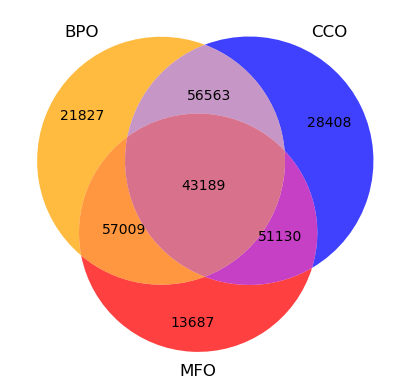

In [11]:
venn3(subsets=(unique_bpo["BPO"].sum(), 
               unique_cco["CCO"].sum(), 
               bpo_cco.shape[0], 
               unique_mfo["MFO"].sum(), 
               bpo_mfo.shape[0], 
               cco_mfo.shape[0], 
               bpo_cco_mfo.shape[0]), 
      set_labels=('BPO', 'CCO', 'MFO'), 
      set_colors=('orange', 'blue', 'red'), alpha=0.75)
plt.show()

In [12]:
del bpo_cco
del bpo_mfo
del cco_mfo
del bpo_cco_mfo
del unique_bpo
del unique_cco
del unique_mfo
del prot_func

## Opening taxonomy

Protein taxonomy refers to the hierarchical classification of proteins according to their evolutionary relationships and structural and functional characteristics. As with general biological taxonomy, which classifies living organisms into groups such as kingdoms, phyla, classes, orders, families, genera, and species, protein taxonomy organizes proteins into categories based on their similarities and differences.

### 1 - Train Tax

In [13]:
train_tax = pd.read_csv('Train/train_taxonomy.tsv', sep='\t')
print(train_tax.info(), end='\n\n')
train_tax

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   EntryID     142246 non-null  object
 1   taxonomyID  142246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ MB
None



,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431
...,...,...
142241,Q5TD07,9606
142242,A8BB17,7955
142243,A0A2R8QBB1,7955
142244,P0CT72,284812


### 2 - Taxonomy Description

In [14]:
test_tax = pd.read_csv('Test/testsuperset-taxon-list.tsv', sep='\t', encoding='ISO-8859-1')
test_tax

,ID,Species
0,9606,homo sapiens[All Names]
1,10090,mus musculus[All Names]
2,10116,Rattus norvegicus
3,3702,Arabidopsis thaliana[All Names]
4,83333,Escherichia coli K-12[all names]
...,...,...
85,8671,Pseudechis porphyriacus (snakes)
86,8673,Pseudonaja textilis (snakes)
87,930089,Bipolaris zeicola 26-R-13 (ascomycetes fungi)
88,559292,Saccharomyces cerevisiae S288C (budding yeast)


### Number of times taxonomyID appears

In [15]:
print(f'Unique Taxonomies: {len(set(train_tax["taxonomyID"]))}')
group_train_tax = train_tax[['taxonomyID']].groupby('taxonomyID').value_counts().sort_values(ascending=False)
group_train_tax.head(10)

Unique Taxonomies: 3156


taxonomyID
9606      25125
3702      14461
10090     14384
7955      12671
7227      12020
10116      8817
559292     5469
185431     5209
6239       4915
284812     4634
dtype: int64

### Approximately 50% of taxonomyID values appear once

Most taxonomies appear a few times or only once. Apparently a large number of proteins have only one taxonomic sample.

In [16]:
per = [0.55, 0.7, 0.8, 0.9, 0.99]
group_train_tax.describe(percentiles=per)

count     3156.000000
mean        45.071610
std        702.487909
min          1.000000
50%          1.000000
55%          2.000000
70%          3.000000
80%          5.000000
90%         10.000000
99%        207.800000
max      25125.000000
dtype: float64

In [17]:
del group_train_tax

## Opening sequence from train_sequence

In [18]:
def read_sequences_from_fasta(file_path, train=True):
    """
    Read protein sequences from a FASTA file and create a DataFrame.

    Parameters:
    file_path (str): Path to the FASTA file containing protein sequences.

    Returns:
    pandas.DataFrame: A DataFrame containing sequences and their corresponding EntryIDs.
    """
    sequence_dicts = []
    if train:
        for record in SeqIO.parse(file_path, 'fasta'):
            sequence_dict = {'sequence': str(record.seq), 'EntryID': record.id}
            sequence_dicts.append(sequence_dict)

        prot_seq = pd.DataFrame(sequence_dicts)
    else:
        for record in SeqIO.parse(file_path, 'fasta'):
            sequence_dict = {'sequence': str(record.seq), 'EntryID': record.id, 'taxonomyID': str(record.description).split('\t')[1]}
            sequence_dicts.append(sequence_dict)

        prot_seq = pd.DataFrame(sequence_dicts)
        
    return prot_seq

In [19]:
file_path = 'Train/train_sequences.fasta'
prot_seq = read_sequences_from_fasta(file_path)
prot_seq.info()

prot_seq = pd.merge(prot_seq, train_tax, how='left', on='EntryID')
prot_seq.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sequence  142246 non-null  object
 1   EntryID   142246 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


,sequence,EntryID,taxonomyID
0,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...,P20536,10249
1,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...,O73864,7955
2,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,O95231,9606


In [20]:
file_path = 'Test/testsuperset.fasta'
prot_seq_test = read_sequences_from_fasta(file_path, train=False)
prot_seq_test.info()
prot_seq_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141865 entries, 0 to 141864
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sequence    141865 non-null  object
 1   EntryID     141865 non-null  object
 2   taxonomyID  141865 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


,sequence,EntryID,taxonomyID
0,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,Q9CQV8,10090
1,MDDREDLVYQAKLAEQAERYDEMVESMKKVAGMDVELTVEERNLLS...,P62259,10090
2,MGDREQLLQRARLAEQAERYDDMASAMKAVTELNEPLSNEDRNLLS...,P68510,10090
3,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,P61982,10090
4,MERASLIQKAKLAEQAERYEDMAAFMKSAVEKGEELSCEERNLLSV...,O70456,10090


## Creating dictionary with EntryID names with numeric values

In [21]:
dict_prot_name = set(prot_seq['EntryID']) | set(prot_seq_test['EntryID']) | set(train_tax['EntryID'])
dict_prot_name = {val: number for number, val in enumerate(dict_prot_name)}

In [22]:
train_terms['EntryID'] = train_terms['EntryID'].map(dict_prot_name).fillna(train_terms['EntryID'])
prot_seq['EntryID'] = prot_seq['EntryID'].map(dict_prot_name).fillna(prot_seq['EntryID'])
prot_seq_test['EntryID'] = prot_seq_test['EntryID'].map(dict_prot_name).fillna(prot_seq_test['EntryID'])
train_tax['EntryID'] = train_tax['EntryID'].map(dict_prot_name).fillna(train_tax['EntryID'])

In [23]:
print(f'Number of protein names: {len(set(dict_prot_name.values()))}')

Number of protein names: 210457


In [24]:
prot_seq['EntryID'] = prot_seq['EntryID'].astype('int32')
prot_seq_test['EntryID'] = prot_seq_test['EntryID'].astype('int32')
train_terms['EntryID'] = train_terms['EntryID'].astype('int32')
train_tax['EntryID'] = train_tax['EntryID'].astype('int32')

In [25]:
train_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363863 entries, 0 to 5363862
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   EntryID  int32 
 1   term     object
 2   BPO      bool  
 3   CCO      bool  
 4   MFO      bool  
dtypes: bool(3), int32(1), object(1)
memory usage: 76.7+ MB


## Evaluating the taxonomy

In [26]:
tax_list = set(test_tax['ID'])
tax_prot_train = set(prot_seq['taxonomyID'])
tax_prot_test = set(prot_seq_test['taxonomyID'])
tax_train = set(train_tax['taxonomyID'])

print(f'Tax List: {len(tax_list)}')
print(f'Tax Prot Train: {len(tax_prot_train)}')
print(f'Tax Prot Test: {len(tax_prot_test)}')
print(f'Tax Train: {len(tax_train)}')

Tax List: 90
Tax Prot Train: 3156
Tax Prot Test: 90
Tax Train: 3156


We will gather all the values that are in tax_prot_test and tax_list that are not inside tax_train and we will put them inside the missing_tax set. The reason is that at first we do not know any function of the proteins that is linked to this taxonomy.

<img src="new_set_with_dif.jpg" alt="New set with differences" width="600" height="600">

In [27]:
missing_tax = set()
all_tax = tax_list.union(tax_prot_test)
all_tax = all_tax.union(tax_train)
len(all_tax)

3265

In [28]:
count = 0
for t in tax_list:
    if t not in tax_train:
        missing_tax.add(t)
        count += 1
print(f'Values from tax_list that are not in tax_train')
print(f'Total: {count}')

Values from tax_list that are not in tax_train
Total: 19


In [29]:
count = 0
for t in tax_prot_test:
    if t not in tax_train:
        missing_tax.add(t)
        count += 1
print(f'Values from tax_prot_test that are not in tax_train')
print(f'Total: {count}')

Values from tax_prot_test that are not in tax_train
Total: 90


In [30]:
count = 0
for t in tax_prot_test:
    if t not in tax_train:
        if t not in tax_list:
            count += 1
print(f'Values from tax_prot_test that are not in tax_train or tax_list')
print(f'Total: {count}')

Values from tax_prot_test that are not in tax_train or tax_list
Total: 90


In [31]:
# taxonomyID that must be handled separately
print(len(missing_tax))
set(list(missing_tax)[:5])

109


{'284811', '559292', 749593, '9555', '9606'}

In [32]:
temp_df = prot_seq[['taxonomyID']].groupby('taxonomyID', as_index=False).value_counts().sort_values(by='count', ascending=False)
temp_df = temp_df[temp_df['taxonomyID'].isin(missing_tax)]
print(f'Total: {temp_df["count"].sum()} or {temp_df["count"].sum()/prot_seq.shape[0]*100:.2f}%')
temp_df

Total: 0 or 0.00%


,taxonomyID,count


There are taxonomies values that we should know more about so that we can better train the model and predict the functions.
As we see above, there is no direct reference to this group within prot_seq.

In [33]:
del temp_df
del count

## Checking the Size of Protein Sequences

Let's compare the length of the training and test proteins to see if any adjustments are needed, see the correlation between these data with respect to protein sizes and number of individuals in those groups.

In [34]:
prot_seq_test['size_seq'] = prot_seq_test['sequence'].map(lambda x: len(x))
print(f'Min. size: {prot_seq_test["size_seq"].min()} - Max. size: {prot_seq_test["size_seq"].max()}')
prot_seq_test.head(3)

Min. size: 2 - Max. size: 35213


,sequence,EntryID,taxonomyID,size_seq
0,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,94140,10090,246
1,MDDREDLVYQAKLAEQAERYDEMVESMKKVAGMDVELTVEERNLLS...,31442,10090,255
2,MGDREQLLQRARLAEQAERYDDMASAMKAVTELNEPLSNEDRNLLS...,109320,10090,246


In [35]:
prot_seq['size_seq'] = prot_seq['sequence'].map(lambda x: len(x))
print(f'Min. size: {prot_seq["size_seq"].min()} - Max. size: {prot_seq["size_seq"].max()}')
prot_seq.head(3)

Min. size: 3 - Max. size: 35375


,sequence,EntryID,taxonomyID,size_seq
0,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...,50982,10249,218
1,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...,134230,7955,354
2,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,69655,9606,258


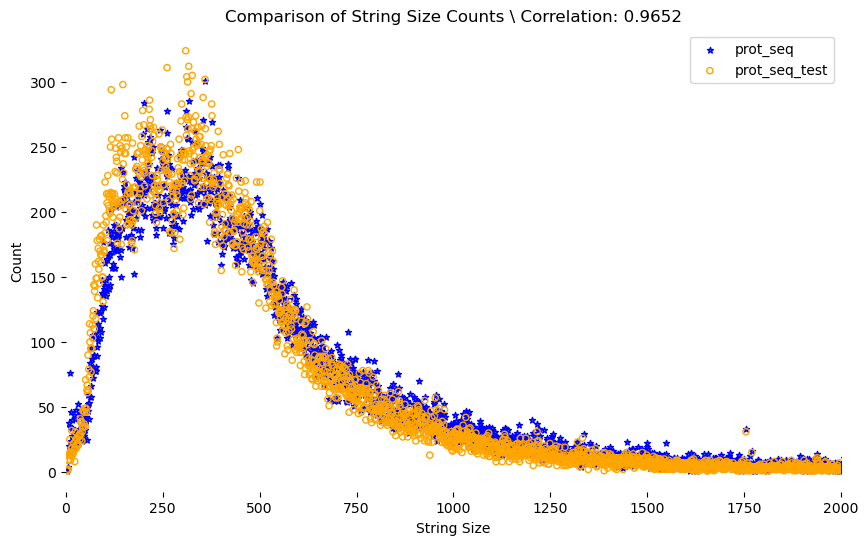

In [36]:
# Compute the count of each value in column "size_seq"
size_seq_counts = prot_seq['size_seq'].value_counts().sort_index()
size_seq_counts_test = prot_seq_test['size_seq'].value_counts().sort_index()

# Create a scatter plot comparing counts
plt.figure(figsize=(10, 6))
plt.scatter(size_seq_counts.index, size_seq_counts.values, label='prot_seq', s=20, marker='*',edgecolors='blue')  # Formato do ponto ajustado (círculo vazado)
plt.scatter(size_seq_counts_test.index, size_seq_counts_test.values, label='prot_seq_test', s=20, marker='o', facecolors='none', edgecolors='orange')  # Formato do ponto ajustado (círculo vazado)

# Calculate Spearman's Correlation
correlation = size_seq_counts.corr(size_seq_counts_test, method='spearman')

# Set the legend with the correlation
legend_text = f'Correlation: {correlation:.4f}'
plt.legend(['prot_seq', 'prot_seq_test'], loc='upper right')

plt.title(f'Comparison of String Size Counts \ {legend_text}')
plt.xlabel('String Size')
plt.ylabel('Count')

# Remove borders from axes
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.grid(False)

# Set the limits of the x axis
plt.xlim(0, 2000)

# display the graph
plt.show()

plt.close()

del correlation
del legend_text

50% of proteins have lengths that appear infrequently. From the graph above these singular sizes are concentrated in very small or very long values.

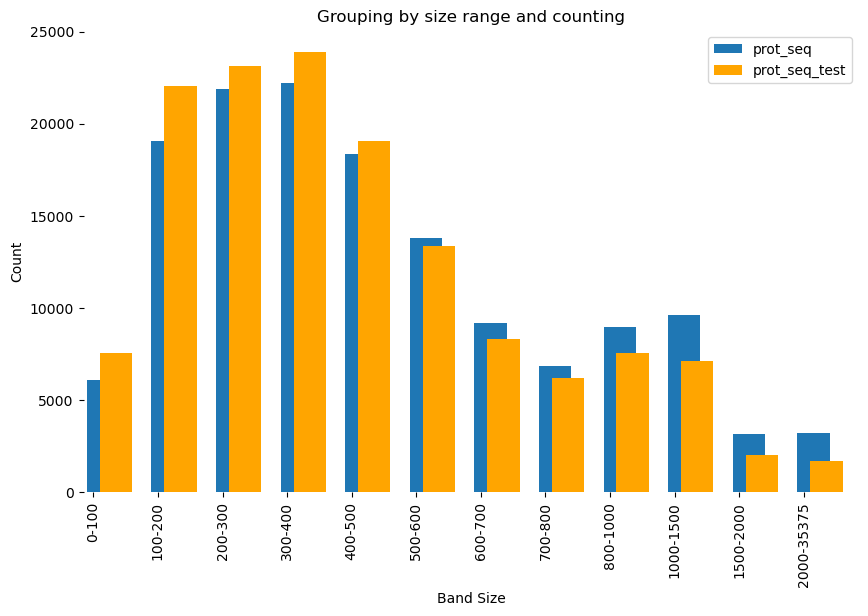

In [37]:
# Set the range limits
highest_value = max(max(prot_seq_test['size_seq']), max(prot_seq['size_seq']))
ranges = [0, 100, 200, 300, 400, 500, 600, 700, 800, 1000, 1500, 2000, highest_value]

# Use pd.cut() to create the categories and count the values
count_by_range1 = pd.cut(prot_seq['size_seq'], bins=ranges, labels=[f'{start}-{end}' for start, end in zip(ranges[:-1], ranges[1:])]).value_counts().sort_index()
count_by_range2 = pd.cut(prot_seq_test['size_seq'], bins=ranges, labels=[f'{start}-{end}' for start, end in zip(ranges[:-1], ranges[1:])]).value_counts().sort_index()

# Create overlay bar chart
plt.figure(figsize=(10, 6))
count_by_range1.plot(kind='bar', position=0.2, label='prot_seq')
count_by_range2.plot(kind='bar', position=-0.2, label='prot_seq_test', color='orange')  # Cor diferente para DF2
plt.title('Grouping by size range and counting')
plt.xlabel('Band Size')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Remove borders from axes
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()

plt.show()
plt.close()

del highest_value
del ranges

## Opening the go_obo file to get the function codes

In [38]:
go_obo = obonet.read_obo('Train/go-basic.obo')
go_obo_nodes = tuple(go_obo.nodes())

## Creating dictionary with terms codes

In [39]:
dict_func = {val: number for number, val in enumerate(go_obo_nodes)}
dict(list(dict_func.items())[:5])

{'GO:0000001': 0,
 'GO:0000002': 1,
 'GO:0000003': 2,
 'GO:0000006': 3,
 'GO:0000007': 4}

## Partial Summary

In [40]:
print(f'Proteins:  {len(dict_prot_name):,}')
print(f'Functions: {len(dict_func):,}')
print(f'Taxonomy:  {len(all_tax):,}')

Proteins:  210,457
Functions: 43,248
Taxonomy:  3,265


## Converting EntryID names and terms to numbers

In [41]:
train_tax['EntryID'] = train_tax['EntryID'].map(dict_prot_name).fillna(train_tax['EntryID'])
train_tax['EntryID'] = train_tax['EntryID'].astype('int32')

In [42]:
train_terms['term'] = train_terms['term'].map(dict_func).fillna(train_terms['term'])
train_terms['term'] = train_terms['term'].astype('int32')

In [43]:
train_terms['EntryID'] = train_terms['EntryID'].map(dict_prot_name).fillna(train_terms['EntryID'])
train_terms['EntryID'] = train_terms['EntryID'].astype('int32')

In [44]:
train_terms = train_terms[['EntryID', 'term']]
train_terms.info()
train_terms.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363863 entries, 0 to 5363862
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   EntryID  int32
 1   term     int32
dtypes: int32(2)
memory usage: 40.9 MB


,EntryID,term
0,114158,5294
1,114158,15838
2,114158,30274


## Dividing functions into two groups

We will divide the functions into two groups. One group will be those that we know the proteins attached to and the other will just be functions that we don't know which proteins are associated with.

<img src="func_known_unknown.jpg" alt="Dividing functions into groups of known and unknown proteins" width="600" height="600">

In [45]:
func_known = set(train_terms['term'])
len(func_known)

31466

In [46]:
func_unknown = set(dict_func.values())-func_known
len(func_unknown)

11782

## Assembling function group

<img src="function_group.jpg" alt="A representation of a group of functions" width="600" height="600">

To assemble the groups of functions, we will first find the first function of the group so that from there we can find the complete group. We will go through all the terms (function) in search of an ancestor. When there is no other previous term (function), this element will be considered the first of the group.

In [47]:
def first_group(go_obo, go_obo_nodes):
    '''
    Identify and return the first functions within a group of functions.

    Parameters:
        go_obo (networkx.DiGraph): A directed graph representing the Gene Ontology hierarchy.
        go_obo_nodes (set): A set of function nodes.

    Returns:
        set: A set containing the first functions in the group of functions.

    Description:
        This function takes a directed graph representing the Gene Ontology hierarchy (go_obo) and a set of function nodes (go_obo_nodes).
        It identifies and returns the set of functions that have no predecessors within the given set, effectively representing the first level
        of functions within a hierarchical grouping.

    Example:
        # Create a directed graph for Gene Ontology hierarchy (go_obo) and a set of function nodes (go_obo_nodes)
        go_obo = ...
        go_obo_nodes = {'function1', 'function2', 'function3'}

        # Get the first functions within the group
        first_functions = first_group(go_obo, go_obo_nodes)

        # Print the result
        print(first_functions)
    '''
    new_go_obo = set(copy.deepcopy(go_obo_nodes))
    
    for func in go_obo_nodes:
        for _ in go_obo.predecessors(func):
            new_go_obo.discard(func)
            
    return set(new_go_obo)

In [48]:
new_go_obo = first_group(go_obo, go_obo_nodes)
print(len(new_go_obo))

23827


In [49]:
def group_func(go_obo, go_obo_nodes):
    '''
    Group related functions and return them in a dictionary.

    Parameters:
        go_obo (networkx.DiGraph): A directed graph representing the Gene Ontology hierarchy.
        go_obo_nodes (set): A set of function nodes.

    Returns:
        dict: A dictionary containing grouped function sets.

    Description:
        This function takes a directed graph representing the Gene Ontology hierarchy (go_obo) and a set of function nodes (go_obo_nodes).
        It groups related functions together and returns them in a dictionary. The dictionary keys correspond to the index of the group, and the values
        are sets of function nodes that belong to that group. Each group consists of a function and its direct and indirect successors in the hierarchy.

    Example:
        # Create a directed graph for Gene Ontology hierarchy (go_obo) and a set of function nodes (go_obo_nodes)
        go_obo = ...
        go_obo_nodes = {'function1', 'function2', 'function3'}

        # Group related functions
        grouped_functions = group_func(go_obo, go_obo_nodes)

        # Print the result
        print(grouped_functions)
    '''
    
    val_set = list()
    dict_func = {}
    
    for func in go_obo_nodes:
        val = {func}
        
        for f in networkx.bfs_successors(go_obo, func):
            val.update(f[1])
            
        val_set.append(val)

    dict_func = {i: set(set_val) for i, set_val in enumerate(val_set)}
    return dict_func

In [50]:
dict_group_func = group_func(go_obo, new_go_obo)
dict(list(dict_group_func.items())[:1])

{0: {'GO:0000339',
  'GO:0000340',
  'GO:0003674',
  'GO:0003676',
  'GO:0003723',
  'GO:0005488',
  'GO:0097159',
  'GO:1901363'}}

In [51]:
# Replaces function names with numerical values

for key, vals in dict_group_func.items():
    dict_group_func[key] = set(dict_func.get(val, val) for val in vals)

dict(list(dict_group_func.items())[:1])    

{0: {233, 234, 2409, 2410, 2433, 3573, 31797, 37071}}

## Separating the taxonomy values with known functions
### func:  taxnomoyID

In [52]:
train_terms = pd.merge(train_terms, train_tax, on='EntryID', how='left')
train_terms.head()

,EntryID,term,taxonomyID
0,114158,5294,1310613
1,114158,15838,1310613
2,114158,30274,1310613
3,114158,19745,1310613
4,114158,4528,1310613


In [53]:
df_func_tax_known = train_terms[['term', 'taxonomyID']].drop_duplicates(subset=['term', 'taxonomyID'])
df_func_tax_known.head()

,term,taxonomyID
0,5294,1310613
1,15838,1310613
2,30274,1310613
3,19745,1310613
4,4528,1310613


In [54]:
dict_func_tax_known = df_func_tax_known.groupby('term')['taxonomyID'].apply(set).to_dict()
del df_func_tax_known
len(dict_func_tax_known)

31466

<img src="dict func tax known.jpg" width="600" heigth="600">

In [55]:
dict(list(dict_func_tax_known.items())[:2])  

{0: {7227, 284812, 559292},
 1: {3702,
  4577,
  4932,
  5691,
  6239,
  7227,
  9606,
  10090,
  44689,
  185431,
  237561,
  284812,
  559292,
  578454}}

## Associating taxonomy and functions by descriptions

Search the description for the correlation between function and taxonomy

<img src="func_tax_description.jpg" alt="Filter tax" width="900" height="600">

Data will be cleaned step by step, names will be substituted for easier searching and some words will have the letter "s" subpressed at the end to reduce differences between singular and plural of a word.

In [56]:
def count_words(text):
    return len(text.split())

def remove_and_replace(text):
    # Remover '-' e substituir por espaço
    cleaned_text = text.replace('-', ' ')
    return cleaned_text

def remove_all_name(text):
    standard = r"\[All names\]|\[all names\]|\[All Names\]$"
    return re.sub(standard, '', text)

def remove_square_brackets(text):
    standard = r'[^a-zA-Z0-9\s]'
    return re.sub(standard, '', text)

def remove_s(text):
    words = text.split()
    cleaned_words = [word[:-1] if word.endswith('s') else word for word in words]
    return ' '.join(cleaned_words)

test_tax['Species'] = test_tax['Species'].apply(remove_and_replace)
test_tax['Species'] = test_tax['Species'].apply(remove_all_name)
test_tax['Species'] = test_tax['Species'].apply(remove_square_brackets)
test_tax['Species'] = test_tax['Species'].str.lower()

dict_missing_tax = dict(zip(test_tax['ID'], test_tax['Species']))

In [57]:
def replace_words_in_dict(text_dict, word_replace_dict):
    replaced_dict = {}
    
    for key, text in text_dict.items():
        # We initialize the replaced text with the original text
        replaced_text = text
        for word_to_replace, replacement_word in word_replace_dict.items():
            # We replace the word in the text
            replaced_text = replaced_text.replace(word_to_replace, replacement_word)
        # We add the replaced text in the new dictionary
        replaced_dict[key] = replaced_text
    return replaced_dict

In [58]:
word_replace_dict = {
    'snakes': 'snake',
    'cobra': 'snake',
    'naja': 'snake'
}

dict_missing_tax = replace_words_in_dict(dict_missing_tax, word_replace_dict)
dict_missing_tax = {key: remove_s(text) for key, text in dict_missing_tax.items()}
dict_missing_tax

{9606: 'homo sapien',
 10090: 'mu musculu',
 10116: 'rattu norvegicu',
 3702: 'arabidopsi thaliana',
 83333: 'escherichia coli k 12',
 7227: 'drosophila melanogaster',
 287: 'pseudomona aeruginosa',
 4896: 'schizosaccharomyce pombe',
 7955: 'danio rerio',
 44689: 'dictyostelium discoideum',
 243273: 'mycoplasma genitalium atcc 33530',
 6239: 'caenorhabditi elegan',
 226900: 'bacillu cereu atcc 14579',
 4577: 'zea may',
 9823: 'su scrofa',
 8355: 'xenopu laevi',
 85962: 'helicobacter pylori 26695',
 99287: 'salmonella enterica subsp enterica serovar typhimurium str lt2',
 160488: 'pseudomona putida kt2440',
 170187: 'streptococcu pneumoniae tigr4',
 223283: 'pseudomona syringae pv tomato str dc3000',
 224308: 'bacillu subtili subsp subtili str 168',
 237561: 'candida albican sc5314',
 243232: 'methanocaldococcu jannaschii dsm 2661',
 321314: 'salmonella enterica subsp enterica serovar choleraesui str sc b67',
 10172: 'bathyergu suillu schreber 1782 common mole rat',
 1072389: 'drepanope

In [59]:
dict_missing_tax[8667] = 'oxyuranu scutellatu scutellatu australian taipan snake'
dict_missing_tax[38281] = 'heteracti magnifica magnificent sea anemone radianthu paumotensi ritteri actinia'

Taxonomy values that we have the description and are present in missing_tax to try to associate with some function.

In [60]:
dict_missing_tax_filter = {key: value for key, value in dict_missing_tax.items() if key in missing_tax}
dict_missing_tax_filter

{321314: 'salmonella enterica subsp enterica serovar choleraesui str sc b67',
 10172: 'bathyergu suillu schreber 1782 common mole rat',
 1072389: 'drepanopeziza brunnea f sp multigermtubi mbm1 ascomycete fungi',
 27300: 'schwanniomyce occidentali klocker 1909 budding yeast',
 120305: 'philodrya olfersii snake',
 186611: 'thrasop jacksonii black tree snake',
 193080: 'rhabdophi tigrinu tigrinu snake',
 284592: 'debaryomyce hansenii cbs767 budding yeast',
 29156: 'austrelap superbu snake',
 292442: 'cryptophi nigrescen snake',
 338838: 'erythrolampru poecilogyru snake',
 338839: 'pseudoferania polylepi water snake',
 412038: 'demansia vestigiata black whip snake',
 749593: 'epicoccum sorghinum ascomycete fungi',
 8654: 'snake nigricolli spitting snake',
 8670: 'oxyuranu scutellatu scutellatu snake',
 8671: 'pseudechi porphyriacu snake',
 930089: 'bipolari zeicola 26 r 13 ascomycete fungi',
 38281: 'heteracti magnifica magnificent sea anemone radianthu paumotensi ritteri actinia'}

## Loading the file with the name and description of the proteins

In [61]:
def desc_prot_func(go_obo_nodes, go_obo): 
    return {'term': go_obo_nodes, 'description': [go_obo.nodes[func]['name'] + ' ' + go_obo.nodes[func]['def'] for func in go_obo_nodes]}

In [62]:
df_desc_prot_func = pd.DataFrame(desc_prot_func(go_obo_nodes, go_obo))
df_desc_prot_func

,term,description
0,GO:0000001,"mitochondrion inheritance ""The distribution of..."
1,GO:0000002,"mitochondrial genome maintenance ""The maintena..."
2,GO:0000003,"reproduction ""The production of new individual..."
3,GO:0000006,high-affinity zinc transmembrane transporter a...
4,GO:0000007,low-affinity zinc ion transmembrane transporte...
...,...,...
43243,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
43244,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
43245,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
43246,GO:2001316,"kojic acid metabolic process ""The chemical rea..."


In [63]:
def count_words(text):
    return len(text.split())

def remove_and_replace(text):
    # Remover '-' e substituir por espaço
    cleaned_text = text.replace('-', ' ')
    return cleaned_text


def remove_all_name(text):
    standard = r"\[All names\]|\[all names\]|\[All Names\]$"
    return re.sub(standard, '', text)

def remove_square_brackets(text):
    standard = r'[^a-zA-Z0-9\s]'
    return re.sub(standard, '', text)

df_desc_prot_func['description'] = df_desc_prot_func['description'].apply(remove_and_replace)
df_desc_prot_func['description'] = df_desc_prot_func['description'].apply(remove_all_name)
df_desc_prot_func['description'] = df_desc_prot_func['description'].apply(remove_square_brackets)
df_desc_prot_func['description'] = df_desc_prot_func['description'].str.lower()

In [64]:
df_desc_prot_func['term'] = df_desc_prot_func['term'].map(dict_func).fillna(df_desc_prot_func['term'])

In [65]:
df_desc_prot_func

,term,description
0,0,mitochondrion inheritance the distribution of ...
1,1,mitochondrial genome maintenance the maintenan...
2,2,reproduction the production of new individuals...
3,3,high affinity zinc transmembrane transporter a...
4,4,low affinity zinc ion transmembrane transporte...
...,...,...
43243,43243,udp 4 deoxy 4 formamido beta l arabinopyranose...
43244,43244,udp 4 deoxy 4 formamido beta l arabinopyranose...
43245,43245,udp 4 deoxy 4 formamido beta l arabinopyranose...
43246,43246,kojic acid metabolic process the chemical reac...


In [66]:
dict_desc_prot_func = dict(zip(df_desc_prot_func['term'], df_desc_prot_func['description']))

In [67]:
word_replace_dict = {
    'snakes': 'snake',
    'cobra': 'snake',
    'naja': 'snake'
}
dict_desc_prot_func = replace_words_in_dict(dict_desc_prot_func, word_replace_dict)
dict_desc_prot_func = {key: remove_s(text) for key, text in dict_desc_prot_func.items()}

### Function fo associating taxonomy and functions by descriptions

In [68]:
def count_words_in_texts(text_A, text_B, n=1):
    '''
    Compare word overlap between two texts.

    Parameters:
        text_A (str): The first text.
        text_B (str): The second text.
        n (int, optional): The minimum number of overlapping words required. Default is 1.

    Returns:
        bool: True if the number of overlapping words is greater than n, otherwise False.

    Description:
        This function takes two input texts (text_A and text_B) and compares the word overlap between them. It counts the number of unique words
        that appear in both texts. If the count is greater than or equal to the specified value (n), the function returns True; otherwise, it returns False.

    Example:
        text1 = "This is a sample text."
        text2 = "A sample text for demonstration."
        result = count_words_in_texts(text1, text2, n=2)
        print(result)  # Output: True
    '''
    # Create sets of unique words for each text
    words_A = set(text_A.split())
    words_B = set(text_B.split())
        
    # Check if the number of overlapping words is greater than n
    return len(words_A.intersection(words_B)) > n


In [69]:
def associating_tax_func(missing_tax, dict_desc_prot_func, dict_missing_tax, n=1):
    '''
    Associate missing taxonomies with functions based on text similarity.

    Parameters:
        missing_tax (set): A set of missing taxonomies.
        dict_desc_prot_func (dict): A dictionary mapping protein descriptions to function keywords.
        dict_missing_tax (dict): A dictionary mapping missing taxonomies to their descriptions.
        n (int, optional): The minimum number of overlapping words required for association. Default is 1.

    Returns:
        dict: A dictionary associating functions with corresponding missing taxonomies.

    Description:
        This function takes a set of missing taxonomies (missing_tax), a dictionary mapping protein descriptions to function keywords (dict_desc_prot_func),
        a dictionary mapping missing taxonomies to their descriptions (dict_missing_tax), and an optional parameter (n) to set the minimum number of overlapping
        words required for association. It associates missing taxonomies with functions by comparing the descriptions of missing taxonomies and function keywords.
        The association is made when the number of overlapping words in the descriptions is greater than or equal to the specified value (n).

    Example:
        missing_taxonomies = {'tax1', 'tax2'}
        protein_function_mapping = {'protein1': 'enzyme', 'protein2': 'transporter'}
        missing_taxonomy_descriptions = {'tax1': 'A description of tax1.', 'tax2': 'Description of tax2.'}
        associated_functions = associating_tax_func(missing_taxonomies, protein_function_mapping, missing_taxonomy_descriptions, n=2)
        print(associated_functions)
    '''
    # Initialize a dictionary to store associations between functions and taxonomies
    new_func_tax = dict()
    
    # Create a deep copy of the set of missing taxonomies
    copy_missing_tax = copy.deepcopy(missing_tax)

    # Iterate through protein descriptions and function keywords
    for protein, func_keywords in dict_desc_prot_func.items():
        associated_taxonomies = set()
        
        # Iterate through missing taxonomies and their descriptions
        for tax, tax_description in dict_missing_tax.items():
            # Check if the description of the protein is associated with the description of the missing taxonomy
            if count_words_in_texts(func_keywords, tax_description, n=n):
                associated_taxonomies.add(tax)
                copy_missing_tax.discard(tax)
        
        # Add the associated taxonomies to the function in the dictionary
        if len(associated_taxonomies) > 0:
            new_func_tax[protein] = associated_taxonomies
    
    return new_func_tax
     

In [70]:
def add_new_func_tax(new_func_tax, dict_func_tax_known):
    '''
    Merge function-taxonomy associations from two dictionaries and add new associations.

    Parameters:
        new_func_tax (dict): A dictionary associating functions with taxonomies.
        dict_func_tax_known (dict): A dictionary of known function-taxonomy associations.

    Returns:
        dict: A merged dictionary containing updated function-taxonomy associations.

    Description:
        This function takes two dictionaries: new_func_tax and dict_func_tax_known. It merges the values of the sets associated with common keys in both dictionaries
        and adds the values of new keys to the dict_func_tax_known dictionary. The result is a dictionary with updated and added function-taxonomy associations.

    Example:
        new_function_taxonomy = {'protein1': {'tax1'}, 'protein2': {'tax2'}}
        known_function_taxonomy = {'protein1': {'tax3'}, 'protein3': {'tax4'}}
        updated_associations = add_new_func_tax(new_function_taxonomy, known_function_taxonomy)
        print(updated_associations)
    '''
    # Iterate through the keys and values in new_func_tax
    for key, value in new_func_tax.items():
        # If the key already exists in dict_func_tax_known, merge the sets
        if key in dict_func_tax_known:
            existing_value = dict_func_tax_known[key]
            merged_value = existing_value.union(value)
            dict_func_tax_known[key] = merged_value
        # If the key is new, add it to dict_func_tax_known
        else:
            dict_func_tax_known[key] = value
            
    return dict_func_tax_known


<img src="group_tax_desc.jpg" alt="Filter tax" width="600" height="600">

We looked within the taxonomic descriptions which were most similar to each other. As there were few technical words in the description, we chose to use n=0, that is, if there were one or more similar words between two descriptions, they would appear in the output dictionary, the key being the main taxonomy and the values being the groups.

<img src="find tax known.jpg" alt="Filter tax" width="600" height="600">

In [71]:
unknown_tax_group = associating_tax_func(missing_tax, dict_missing_tax, dict_missing_tax, n=0)
print(len(unknown_tax_group), end='\n\n')
print(dict(list(unknown_tax_group.items())[:10]))

91

{9606: {9606}, 10090: {10090}, 10116: {10116}, 3702: {3702}, 83333: {83333}, 7227: {7227}, 287: {160488, 223283, 287}, 4896: {4896, 284812}, 7955: {7955}, 44689: {44689}}


In [72]:
# Adding new values from the secondary group to the main group, provided that 
# within the secondary group there are values in common.
count = 0
for key, value in dict_func_tax_known.items():
    for value_2 in unknown_tax_group.values():
        if value_2 & value:
            new_val = value.union(value_2)
            dict_func_tax_known[key] = new_val
            if len(new_val) > len(value):
                count += 1
            
print(f'total changes: {count}')
print(dict(list(dict_func_tax_known.items())[:1]))

total changes: 126411
{0: {27300, 5478, 284811, 284812, 284591, 284592, 28985, 660122, 7227, 559292}}


In [73]:
# Crossing the taxonomy description information with the function description to known 
# withing taxonomies that function occurs.

new_func_tax = associating_tax_func(missing_tax, dict_desc_prot_func, dict_missing_tax_filter)
print(dict(list(new_func_tax.items())[:2]))

{84: {284592, 27300}, 88: {284592, 27300}}


In [74]:
# Adding new values from the secondary group to the main group, provided that 
# within the secondary group there are values in common.

for key, value in new_func_tax.items():
    for value_2 in unknown_tax_group.values():
        if value_2 & value:
            new_val = value.union(value_2)
            new_func_tax[key] = new_val
            
print(dict(list(new_func_tax.items())[:5]))

{84: {27300, 5478, 284811, 284591, 284592, 28985, 660122, 559292}, 88: {27300, 5478, 284811, 284591, 284592, 28985, 660122, 559292}, 362: {27300, 5478, 284811, 284591, 284592, 28985, 660122, 559292}, 492: {1072389, 367110, 498257, 2587412, 749593, 660122, 229533, 930089, 48703, 235443, 227321, 426428, 330879}, 2457: {1072389, 367110, 930089, 48703, 498257, 235443, 2587412, 227321, 660122, 426428, 229533, 749593, 330879}}


In [75]:
new_missing_tax = copy.deepcopy(missing_tax)
for value in dict_func_tax_known.values():
    for v in value:
        if v in missing_tax:
            new_missing_tax.discard(v)
print(f'Missing tax: {len(missing_tax)}')
print(f'Missing tax after discard {len(new_missing_tax)}')
print(new_missing_tax)

Missing tax: 109
Missing tax after discard 91
{'559292', '284811', '9555', '9606', '981087', '8090', '7460', '44689', '498257', '83332', '10116', '284812', '367110', '4577', '223283', '10172', '229533', '8667', '10090', '3218', '9823', '235443', '186611', '7159', '27300', '8673', '2587412', '321314', '5478', '330879', '9615', '7227', '39947', '9031', '8355', '284592', '287', '284591', '226900', '243232', '7962', '224308', '294381', '9541', '48703', '749593', '412038', '508771', '9913', '426428', '120305', '1072389', '271848', '186763', '9601', 38281, '3702', '6239', '6253', '100989', '227321', '515849', '111177', '8654', '1094619', '3197', '99287', '338839', '28985', '38281', '930089', '237561', '5823', '8671', '8364', '70142', '170187', '29156', '160488', '196418', '193080', '36329', '660122', '7955', '292442', '8670', '126793', '85962', '338838', '243273', '83333'}


In [76]:
print(f'dict_func_tax_known: {len(dict_func_tax_known)}')
dict_func_tax_known = add_new_func_tax(new_func_tax, dict_func_tax_known)
print(f'dict_func_tax_known: {len(dict_func_tax_known)}')

dict_func_tax_known: 31466
dict_func_tax_known: 31473


In [77]:
del new_missing_tax
del dict_missing_tax_filter
del new_func_tax
del unknown_tax_group
del dict_desc_prot_func
del dict_missing_tax

## Function Group Keys Where All Unknown

In [78]:
def group_func_all_unknown(dict_group_func, func_unknown):
    '''
    Identify function groups where all functions have unknown taxonomy.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        func_unknown (set): A set of functions with unknown taxonomy.

    Returns:
        set: A set of keys (function group names) where all functions have unknown taxonomy.

    Description:
        This function takes a dictionary (dict_group_func) that maps function groups to sets of associated functions and a set (func_unknown) of functions
        with unknown taxonomy. It identifies and returns a set of keys (function group names) where all functions in the group have unknown taxonomy.

    Example:
        function_groups = {'group1': {'func1', 'func2'}, 'group2': {'func3'}}
        unknown_functions = {'func2', 'func3'}
        result = group_func_all_unknown(function_groups, unknown_functions)
        print(result)  # Output: {'group2'}
    '''
    # Use a set comprehension to iterate through dictionary items and check if all functions are unknown
    return {key for key, val in dict_group_func.items() if set(val).issubset(func_unknown)}


In [79]:
set_group_func_all_unknown = group_func_all_unknown(dict_group_func, func_unknown)
len(set_group_func_all_unknown)

0

## Function Group Keys Where There Are One Or More Unknowns

In [80]:
def group_func_any_unknown(dict_group_func, func_unknown, n_unknown=1, return_dict=False):
    '''
    Identify function groups with a specific number of functions having unknown taxonomy.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        func_unknown (set): A set of functions with unknown taxonomy.
        n_unknown (int, optional): The desired number of functions with unknown taxonomy in a group. Default is 1.
        return_dict (bool, optional): If True, return a dictionary with the identified groups and their associated functions. Default is False.

    Returns:
        set or dict: A set of keys (function group names) or a dictionary containing identified function groups with their associated functions.

    Description:
        This function takes a dictionary (dict_group_func) that maps function groups to sets of associated functions, a set (func_unknown) of functions
        with unknown taxonomy, and an optional parameter (n_unknown) to specify the desired number of functions with unknown taxonomy in a group. It
        identifies and returns a set of keys (function group names) or a dictionary containing the identified function groups that meet the specified
        criteria.

    Example:
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func3', 'func4'}}
        unknown_functions = {'func2', 'func3'}
        result = group_func_any_unknown(function_groups, unknown_functions, n_unknown=2, return_dict=True)
        print(result)  # Output: {'group1': {'func1', 'func2', 'func3'}}
    '''
    # Initialize a set to store groups that meet the criteria
    set_group_func_any_unknown = set()
    
    # Iterate through dictionary items and check if the number of unknown functions meets the criteria
    for key, val in dict_group_func.items():
        if len(val.intersection(func_unknown)) == n_unknown:
            set_group_func_any_unknown.add(key)
            
    # Return the result based on the value of return_dict
    if return_dict:
        return {key: dict_group_func[key] for key in set_group_func_any_unknown}
    else:
        return set_group_func_any_unknown

In [81]:
set_group_func_any_unknown = group_func_any_unknown(dict_group_func, func_unknown, n_unknown=1)
len(set_group_func_any_unknown)

7520

In [82]:
def size_group_func_any_unknown(dict_group_func, set_group_func_any_unknown, larger_group=2):
    '''
    Determine function groups of a certain size with specific criteria.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        set_group_func_any_unknown (set): A set of function group names that meet specific criteria.
        larger_group (int, optional): The minimum size of a function group to be considered. Default is 2.

    Returns:
        set: A set of function group names that meet the specified criteria.

    Description:
        This function takes a dictionary (dict_group_func) that maps function groups to sets of associated functions, a set (set_group_func_any_unknown)
        of function group names that meet specific criteria, and an optional parameter (larger_group) to specify the minimum size of a function group
        to be considered. It identifies and returns a set of function group names that meet the specified size and criteria.

    Example:
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func4', 'func5'}}
        selected_groups = {'group1'}
        result = size_group_func_any_unknown(function_groups, selected_groups, larger_group=3)
        print(result)  # Output: {'group1'}
    '''
    # Initialize a temporary set to store function group names that meet the size criterion
    temp_set_group_func_any_unknown = set()
    
    # Iterate through selected function group names and check their size
    for key in set_group_func_any_unknown:
        if len(dict_group_func[key]) > larger_group:
            temp_set_group_func_any_unknown.add(key)
            
    return temp_set_group_func_any_unknown

In [83]:
set_size_group_func_any_unknown = size_group_func_any_unknown(dict_group_func, set_group_func_any_unknown, larger_group=2)
len(set_size_group_func_any_unknown)

7520

## Finding The Amount of Unknown Functions Within Each Group, Yhe Size And Number Of Elements

In [84]:
def count_group_size(count_dict):
    '''
    Count and return the sizes of groups in a dictionary.

    Parameters:
        count_dict (dict): A dictionary containing group names as keys and sets of associated items as values.

    Returns:
        dict: A dictionary mapping group sizes to their respective frequency.

    Description:
        This function takes a dictionary (count_dict) that maps group names to sets of associated items. It counts the sizes of the groups and returns a
        dictionary that maps the group sizes to their respective frequency.

    Example:
        group_sizes = {'group1': {'item1', 'item2'}, 'group2': {'item3', 'item4', 'item5'}}
        result = count_group_size(group_sizes)
        print(result)  # Output: {2: 1, 3: 1}
    '''
    # Initialize a dictionary to store group sizes and their frequencies
    dict_count = dict()
    
    # Iterate through dictionary items and count group sizes
    for key, val in count_dict.items():
        size = len(val)
        if size not in dict_count:
            dict_count[size] = 0
        dict_count[size] += 1
        
    # Return a sorted dictionary of group sizes and their frequencies
    return {k: dict_count[k] for k in sorted(dict_count)}

In [85]:
def count_unknown_funct(dict_group_func, func_unknown):
    '''
    Count the number of unknown functions in each group.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        func_unknown (set): A set of functions with unknown taxonomy.

    Returns:
        set: A set containing the count of unknown functions in each group.

    Description:
        This function takes a dictionary (dict_group_func) that maps function groups to sets of associated functions and a set (func_unknown) of functions
        with unknown taxonomy. It counts the number of unknown functions in each group and returns a set containing the count for each group.

    Example:
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func4'}}
        unknown_functions = {'func2', 'func3'}
        result = count_unknown_funct(function_groups, unknown_functions)
        print(result)  # Output: {2, 0}
    '''
    # Use a set comprehension to iterate through dictionary values and count unknown functions
    return {len(val.intersection(func_unknown)) for val in dict_group_func.values()}

In [86]:
def organize_dictionary(dict_out):
    '''
    Organize dictionaries within dictionaries based on key and value sorting.

    Parameters:
        dict_out (dict): A dictionary containing dictionaries as values.

    Returns:
        dict: An organized dictionary with sorted keys and values.

    Description:
        This function takes a dictionary (dict_out) that contains dictionaries as values. It first sorts the keys of the outer dictionary in ascending order.
        Then, for each inner dictionary, it sorts the keys in descending order. The result is an organized dictionary with both outer and inner dictionaries
        sorted based on the specified sorting criteria.

    Example:
        outer_dict = {'group1': {'func1': 10, 'func2': 5}, 'group2': {'func3': 8, 'func4': 12}}
        result = organize_dictionary(outer_dict)
        print(result)
        # Output:
        # {'group1': {'func2': 5, 'func1': 10}, 'group2': {'func4': 12, 'func3': 8}}
    '''
    # Sort the outer dictionary based on keys
    dict_out = dict(sorted(dict_out.items()))
    
    # Sort inner dictionaries based on values in descending order
    for key, value in dict_out.items():
        dict_out[key] = dict(sorted(value.items(), reverse=True))
        
    return dict_out

In [87]:
def tax_search_compass(dict_group_func, func_unknown):
    '''
    Search for patterns in groups of functions with unknown taxonomy.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        func_unknown (set): A set of functions with unknown taxonomy.

    Returns:
        dict: A dictionary containing patterns of unknown functions in function groups.

    Description:
        This function takes a dictionary (dict_group_func) that maps function groups to sets of associated functions and a set (func_unknown) of functions
        with unknown taxonomy. It searches for patterns in the groups of functions with unknown taxonomy, counting the occurrence of specific numbers of
        unknown functions and the sizes of groups containing those unknown functions. The result is an organized dictionary that provides insights into these patterns.

    Example:
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func2', 'func4'}}
        unknown_functions = {'func2', 'func3'}
        result = tax_search_compass(function_groups, unknown_functions)
        print(result)
        # Output: 
        # {
        #   1: {3: 1},  # 1 unknown function in a group of size 3
        #   2: {2: 1}   # 2 unknown functions in a group of size 2
        # }
    '''
    # Initialize a dictionary to store patterns of unknown functions in groups
    dict_out = dict()
    
    # Count the occurrences of different numbers of unknown functions
    n_unknowns = count_unknown_funct(dict_group_func, func_unknown)
    
    # Iterate through the counts of unknown functions
    for n_unknown in n_unknowns:
        # Get function groups with the specific count of unknown functions
        dict_group_func_n_unknown = group_func_any_unknown(dict_group_func, func_unknown, n_unknown=n_unknown, return_dict=True)
        # Count the sizes of those function groups
        dict_out[n_unknown] = count_group_size(dict_group_func_n_unknown)
    
    # Organize and return the resulting patterns dictionary
    return organize_dictionary(dict_out)


In [88]:
# Example
tax_search_compass(dict_group_func, func_unknown)[7]

{89: 1, 66: 2, 60: 1, 57: 1, 56: 1, 46: 1, 33: 1, 26: 1, 9: 7}

In [89]:
def create_dict(dict_group_func, keys):
    '''Takes keys from groups of functions and returns keys:values'''
    return {i: dict_group_func[i] for i in keys}

In [90]:
# Function groups have no known taxonomy

dict_group_func_all_unknown = create_dict(dict_group_func, set_group_func_all_unknown)
len(dict_group_func_all_unknown)

0

In [91]:
# Groups contain three or more elements with only one unknown

dict_group_func_any_unknown = create_dict(dict_group_func, set_size_group_func_any_unknown)
print(len(dict_group_func_any_unknown))
dict(list(dict_group_func_any_unknown.items())[:1])

7520


{1: {4566,
  5293,
  5294,
  6287,
  6757,
  10198,
  18061,
  18062,
  18086,
  19728,
  24428,
  25138,
  28841,
  29380,
  29594}}

## Count of Group Sizes

In [92]:
# Functions with all elements with unknown taxonomy
print(count_group_size(dict_group_func_all_unknown))

{}


In [93]:
# Functions with some elements with unknown taxonomy
# Demonstration of the size of the function groups (keys) and the number of groups with this size (values).

print(count_group_size(dict_group_func_any_unknown))

{3: 45, 4: 167, 5: 506, 6: 1844, 7: 957, 8: 316, 9: 414, 10: 201, 11: 173, 12: 150, 13: 180, 14: 142, 15: 170, 16: 155, 17: 99, 18: 103, 19: 95, 20: 97, 21: 88, 22: 94, 23: 121, 24: 87, 25: 74, 26: 96, 27: 71, 28: 73, 29: 71, 30: 56, 31: 55, 32: 48, 33: 49, 34: 38, 35: 45, 36: 35, 37: 51, 38: 16, 39: 29, 40: 24, 41: 18, 42: 20, 43: 32, 44: 24, 45: 23, 46: 17, 47: 21, 48: 21, 49: 20, 50: 17, 51: 18, 52: 17, 53: 14, 54: 19, 55: 12, 56: 7, 57: 14, 58: 9, 59: 9, 60: 17, 61: 9, 62: 7, 63: 12, 64: 10, 65: 4, 66: 9, 67: 11, 68: 4, 69: 6, 70: 6, 71: 3, 72: 1, 74: 5, 75: 5, 76: 3, 77: 5, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 84: 1, 85: 1, 86: 3, 87: 1, 88: 1, 89: 1, 91: 1, 92: 2, 93: 2, 94: 1, 98: 5, 99: 1, 100: 1, 103: 1, 104: 1, 106: 1, 116: 1, 119: 1}


In [94]:
del set_group_func_any_unknown
del set_group_func_all_unknown
del set_size_group_func_any_unknown
del dict_group_func_all_unknown

## Looking for Common taxonomy And AssigningTo Functions With Unknown taxonomy

In [95]:
def find_function_group(func, dict_group_func_any_unknown):
    '''Searches for the function of the protein that is in the values preserving the initial key number'''
    return {key: val for key, val in dict_group_func_any_unknown.items()if func in val}

In [96]:
copy_dict_group_func_any_unknown = copy.deepcopy(dict_group_func_any_unknown)
copy_dict_func_tax_known = copy.deepcopy(dict_func_tax_known)

In [97]:
# Example of role search in groups with roles

func = 33017

example_1 = find_function_group(func, copy_dict_group_func_any_unknown)
example_1

{992: {2001,
  4806,
  4889,
  4890,
  5293,
  6757,
  11763,
  13864,
  24411,
  32756,
  33017,
  33022,
  33023}}

Let's extract sets with the taxonomies of the functions we know. We will use check_tax_known.
<img src="check tax known.jpg" wdth="600" heigth="600">

In [98]:
def check_tax_known(func, find_function_group, dict_func_tax_known):
    '''Checking all taxonomies of the functions that are together with searched function.
    Returns a dictionary from Function: list of taxonomies'''
    list_out = []
    for key, values in find_function_group.items():
        for f in values:
            if f in dict_func_tax_known.keys():
                list_out.append(dict_func_tax_known[f])
        
    return {func: list_out}

In [99]:
# The searched function is now the key and the value is a list with the set
# of taxonomies of group functions

example_2 = check_tax_known(func, example_1, dict_func_tax_known)

In [100]:
def find_values_in_majority(groups_dict, num_groups):
    '''
    Find values that appear in the majority of groups.

    Parameters:
        groups_dict (dict): A dictionary containing groups as keys and sets of values as values.
        num_groups (int): The minimum number of groups in which a value should appear to be considered in the majority.

    Returns:
        set: A set of values that appear in the majority of groups.

    Description:
        This function takes a dictionary (groups_dict) that maps groups to sets of associated values and an integer (num_groups) representing the minimum
        number of groups in which a value should appear to be considered in the majority. It counts the occurrences of values across all groups and
        identifies the values that appear in the majority of groups. The result is a set of values that satisfy the specified criteria.

    Example:
        groups_data = {'group1': [{'value1', 'value2'}, {'value3'}], 'group2': [{'value1', 'value4'}, {'value2'}]}
        minimum_group_count = 2
        result = find_values_in_majority(groups_data, minimum_group_count)
        print(result)  # Output: {'value1'}
    '''
    # Initialize a dictionary to count the occurrences of values across groups
    value_count = {}

    # Iterate through group values and count occurrences of values
    for group_values in groups_dict.values():
        for value_set in group_values:
            for value in value_set:
                value_count[value] = value_count.get(value, 0) + 1

    # Find values that appear in the majority of groups
    majority_values = {value for value, count in value_count.items() if count >= num_groups}

    return majority_values


In [101]:
groups_dict = {
    1: [{1, 2, 3}, {2, 3, 4}, {1, 3, 5}],
}

num_groups = 2
result = find_values_in_majority(groups_dict, num_groups)
print(result)  # Output: {2, 3, 4}

del groups_dict
del num_groups
del result

{1, 2, 3}


## Search for missing taxonomies

We will look for the most common taxonomies for the group of functions. Thus we will have a reasonable certainty in several cases in which taxonomies the complete group of those functions acts.


<img src="diagrama venn 01.jpg" width="900" height="600">

When in a group we do not know the values which are the proteins and taxonomies linked to it we will have something similar to the scheme below.


<img src="diagrama venn 02.jpg" width="900" height="600">



Once the taxonomies of Func 03, for example, have been found, they will be added to the main dictionary so that they can contribute to future searches.

The functions below are designed to start searching the largest groups and least known functions.


<img src="filter_taxonomies.jpg" width="900" height="600">

In [102]:
def common_tax_group(dict_check_tax_known, n_groups=2):
    '''The taxonomies of all groups are cross-referenced and keep those that appear in all groups
    A dictionary is returned, with the key being the searched function and the 
    value being the common taxonomies found.'''
    
    for keys, values in dict_check_tax_known.items():
        if len(values)==0:       
            tax_common = values
        else:
            tax_common = reduce(lambda a, b: a.intersection(b), values)
            if len(tax_common) == 0:
                values = {keys: dict_check_tax_known[keys]}
                tax_common = find_values_in_majority(values, n_groups)
        
    return {keys: tax_common}

In [103]:
example_3 = common_tax_group(example_2)
example_3

{33017: {6239, 7227, 7955, 9606, 10090, 10116}}

In [104]:
copy_dict_func_tax_known = copy.deepcopy(dict_func_tax_known)

print(f'Size dict_func_tax_known {len(copy_dict_func_tax_known)}')

Size dict_func_tax_known 31473


In [105]:
def complete_tax(func_unknown, dict_group_func_any_unknown, dict_func_tax_known, n_groups=2):
    '''Returns the {function : taxonomy} with new functions;
       Returns set with unknown functions that could not be completed'''
    
    dict_out = dict()
    turn = 0
    out_func_unknown = copy.deepcopy(func_unknown)
    
    for func in func_unknown:

        dict_find_function_group = find_function_group(func, dict_group_func_any_unknown)
        dict_check_tax_known = check_tax_known(func, dict_find_function_group, dict_func_tax_known)
        dict_common_tax_group = common_tax_group(dict_check_tax_known, n_groups=n_groups)
        
        if len(dict_common_tax_group[func])==0:
            continue
            
        if func not in dict_func_tax_known:
            dict_func_tax_known.update(dict_common_tax_group)
            out_func_unknown.discard(func)
        else:
            val_1 = dict_func_tax_known[func]
            val_2 = dict_common_tax_group[func]
            dict_func_tax_known[func] = val_1.union(val_2)
            
    
    return dict_func_tax_known, out_func_unknown

In [106]:
new_dict_group_func_any_unknow, test_func_unknown = complete_tax({33017}, copy_dict_group_func_any_unknown, copy_dict_func_tax_known)

print(f'Size dict_func_tax_known {len(copy_dict_func_tax_known)}')
print(f'Size test_func_unknown {len(test_func_unknown)}')
print(dict(list(new_dict_group_func_any_unknow.items())[:2]))

Size dict_func_tax_known 31474
Size test_func_unknown 0
{0: {27300, 5478, 284811, 284812, 284591, 284592, 28985, 660122, 7227, 559292}, 1: {9606, 284811, 284812, 44689, 578454, 660122, 27300, 284591, 284592, 28985, 7227, 5691, 559292, 4932, 185431, 6239, 4577, 5478, 10090, 3702, 237561}}


In [107]:
del new_dict_group_func_any_unknow
del copy_dict_func_tax_known
del test_func_unknown
del example_1
del example_2
del example_3
del dict_group_func_any_unknown
del copy_dict_group_func_any_unknown

## Merging def from function groups

In [108]:
copy_func_unknown = {f for f in func_unknown if f not in dict_func_tax_known}
copy_dict_group_func = copy.deepcopy(dict_group_func)
copy_dict_func_tax_known = copy.deepcopy(dict_func_tax_known)


print(f'Size dict_func_tax_known {len(copy_dict_func_tax_known)}')
print(f'Size copy_func_unknown {len(copy_func_unknown)}')
print(f'Size dict_group_func {len(copy_dict_group_func)}')

Size dict_func_tax_known 31473
Size copy_func_unknown 11775
Size dict_group_func 23827


In [109]:
def function_groups_without_tax(dict_group_func, dict_func_tax_known, func_unknown, n_groups):
    '''
    Refine the assignment of taxonomy to function groups without taxonomic information.

    Parameters:
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        dict_func_tax_known (dict): A dictionary mapping functions to known taxonomic information.
        func_unknown (set): A set of functions without taxonomic information.
        n_groups (int): The desired number of function groups.

    Returns:
        tuple: A tuple containing the refined dictionary mapping functions to known taxonomic information and the updated set of functions without taxonomic information.

    Description:
        This function refines the assignment of taxonomy to function groups that lack taxonomic information. It iteratively searches for patterns within the
        function groups, identifies larger function groups with certain characteristics, and attempts to complete the taxonomic assignment using available information.
        The process continues until the taxonomic assignment cannot be further refined or a maximum number of iterations is reached.

    Example:
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func4', 'func5'}}
        known_taxonomy = {'func1': 'tax1', 'func4': 'tax2'}
        unknown_functions = {'func2', 'func3', 'func5'}
        num_groups = 2
        result = function_groups_without_tax(function_groups, known_taxonomy, unknown_functions, num_groups)
        print(result)
        # Output: ({'func1': 'tax1', 'func4': 'tax2'}, set())
    '''
    loop = True
    
    count_loop = 0
    has_not_changed = 0
    
    while loop:
        temp_func_unknown = copy.deepcopy(func_unknown)
        count_loop += 1
        
        key_func_larger_group = tax_search_compass(dict_group_func, func_unknown)
        
        n_unknowns = list(key_func_larger_group.keys())
        n_unknowns.remove(0) 
        
        for n_unknown in n_unknowns:
            for larger_group in key_func_larger_group[n_unknown].keys():
                
                set_group_func_any_unknown = group_func_any_unknown(dict_group_func, func_unknown, n_unknown=n_unknown)
                
                set_size_group_func_any_unknown = size_group_func_any_unknown(dict_group_func, set_group_func_any_unknown, larger_group=larger_group)
                
                dict_group_func_any_unknown = create_dict(dict_group_func, set_size_group_func_any_unknown)
                
                dict_func_tax_known, func_unknown = complete_tax(func_unknown, dict_group_func_any_unknown, dict_func_tax_known, n_groups)
                
            if temp_func_unknown == func_unknown:
                has_not_changed += 1
                
        if len(func_unknown) == 0 or has_not_changed > 3:
            loop = False

    return dict_func_tax_known, func_unknown

In [110]:
new_dict_func_tax_known, new_func_unknown = function_groups_without_tax(copy_dict_group_func, copy_dict_func_tax_known, copy_func_unknown, n_groups=2)

In [111]:
print(f'Size new_dict_func_tax_known {len(new_dict_func_tax_known)}')
print(f'Size new_func_unknown {len(new_func_unknown)}')

Size new_dict_func_tax_known 43193
Size new_func_unknown 55


In [112]:
print(dict(list(new_dict_func_tax_known.items())[:2]))

{0: {27300, 5478, 284811, 284812, 284591, 284592, 28985, 660122, 7227, 559292}, 1: {9606, 284811, 284812, 44689, 578454, 660122, 27300, 284591, 284592, 28985, 7227, 5691, 559292, 4932, 185431, 6239, 4577, 5478, 10090, 3702, 237561}}


## Completing Taxonomy 

In [113]:
def add_tax_func_not_interception(new_func_unknown, dict_group_func, new_dict_func_tax_known):
    '''
    Add taxonomic information to functions with no known taxonomy, avoiding intersections.

    Parameters:
        new_func_unknown (set): A set of functions with unknown taxonomy.
        dict_group_func (dict): A dictionary mapping function groups to sets of associated functions.
        new_dict_func_tax_known (dict): A dictionary mapping functions to known taxonomic information.

    Returns:
        dict: A dictionary mapping functions to sets of inferred taxonomic information.

    Description:
        This function adds taxonomic information to functions without known taxonomy, ensuring that the inferred taxonomic information does not intersect
        with any existing taxonomic information for the same functions. It iterates through each function, searches for function groups containing the
        function, and checks for known taxonomic information. It then unites the inferred taxonomic information from multiple function groups and returns
        a dictionary mapping functions to their inferred taxonomic information.

    Example:
        unknown_functions = {'func2', 'func3'}
        function_groups = {'group1': {'func1', 'func2', 'func3'}, 'group2': {'func4', 'func5'}}
        known_taxonomy = {'func1': {'tax1'}, 'func4': {'tax2'}}
        result = add_tax_func_not_interception(unknown_functions, function_groups, known_taxonomy)
        print(result)
        # Output: {'func2': {'tax1'}, 'func3': {'tax1'}}
    '''
    dict_func_tax_missing = dict()

    for func in new_func_unknown:

        dict_find_function_group = find_function_group(func, dict_group_func)
        dict_check_tax_known = check_tax_known(func, dict_find_function_group, new_dict_func_tax_known)

        united_tax = set()

        for conjunto in dict_check_tax_known.values():
            united_tax.update(*conjunto)

        dict_func_tax_missing[func] = united_tax

    return dict_func_tax_missing

In [114]:
dict_func_tax_missing = add_tax_func_not_interception(new_func_unknown, dict_group_func, new_dict_func_tax_known)
len(dict_func_tax_missing)

55

In summary, the code is combining taxonomy information for functions from two dictionaries (new_dict_func_tax_known and dict_func_tax_missing) and ensuring that there are no duplicates in the taxonomy values associated with each function. The end result is the number of elements in the new_dict_func_tax_known dictionary.

In [115]:
for key, value in dict_func_tax_missing.items():
    
    if key not in new_dict_func_tax_known:
        new_dict_func_tax_known[key] = dict_func_tax_missing[key]
    else:
        val_1 = new_dict_func_tax_known[key]
        val_2 = dict_func_tax_missing[key]
        new_dict_func_tax_known[key] = val_1.union(val_2)
        
len(new_dict_func_tax_known)

43248

In [116]:
new_dict_func_tax_known = add_new_func_tax(dict_func_tax_missing, new_dict_func_tax_known)
len(new_dict_func_tax_known)

43248

In [117]:
del dict_func_tax_missing
del new_func_unknown

In [118]:
def uniting_group(dict_check_tax_known, n_groups=2):
    '''
    Unite taxonomic information within function groups, prioritizing common or majority-based taxonomic assignments.

    Parameters:
        dict_check_tax_known (dict): A dictionary mapping function group numbers to lists of inferred taxonomic information.
        n_groups (int): The minimum number of function groups required for majority-based taxonomic assignment.

    Returns:
        dict: A dictionary mapping function group numbers to sets of unified taxonomic information.

    Description:
        This function unites taxonomic information within function groups, considering common or majority-based taxonomic assignments.
        It takes a dictionary `dict_check_tax_known` that maps function group numbers to lists of inferred taxonomic information for each function
        in the group. The function groups are prioritized based on common taxonomic information, then majority-based taxonomic information,
        and finally, the union of all taxonomic assignments if no common or majority information is found. The parameter `n_groups` specifies
        the minimum number of function groups required for majority-based taxonomic assignment.

    Example:
        tax_assignments = {'group1': [{'tax1', 'tax2'}, {'tax1'}], 'group2': [{'tax2'}]}
        num_groups = 2
        result = uniting_group(tax_assignments, num_groups)
        print(result)
        # Output: {'group1': {'tax1', 'tax2'}, 'group2': {'tax2'}}
    '''
    dict_group_tax_out = dict()
    
    # Iterate through the function group numbers and inferred taxonomic information lists
    for n_group, values in dict_check_tax_known.items():

        # Calculate the intersection of taxonomic assignments for the current function group
        tax_common = reduce(lambda a, b: a.intersection(b), values)
        
        # If there is no common taxonomic assignment, attempt to find a majority-based assignment
        if len(tax_common) == 0:
            tax_common = find_values_in_majority({n_group: values}, n_groups)
            
            # If there is still no majority-based assignment, use the union of all taxonomic assignments
            if len(tax_common) == 0:
                tax_common = set().union(*values)
        
        # Store the unified taxonomic information for the current function group number
        dict_group_tax_out[n_group] = tax_common
        
    return dict_group_tax_out

In [119]:
def n_group_tax(dict_group_func, new_dict_func_tax_known, n_groups):
    temp_dict_group_tax = dict()
    
    for n_group, group in dict_group_func.items():
        temp_dict_group_tax[n_group] = [new_dict_func_tax_known[func] for func in group]
        
    return uniting_group(temp_dict_group_tax, n_group)

In [120]:
dict_group_tax = n_group_tax(dict_group_func, new_dict_func_tax_known, n_groups=4)
len(dict_group_tax)

23827

## Splitting groups into training and testing to find proteins for unknown functions

In [121]:
def find_key(dict_x, number_val):
    return [key for key, val in dict_x.items() if val==number_val][0]

In [122]:
def current_group_func(set_func_train, set_func_test, dict_group_func):
    {item for pair in (X | y) for item in pair}
    
    dict_groups_func_find = find_function_group(n_func, dict_group_func)    
    return [current_group for current_group in dict_groups_func_find.values()]

In [123]:
def arrange_x_y(pred_set, func_unknown):
    list_out = [(x_y[1], x_y[0]) if x_y[0] in func_unknown else x_y for x_y in pred_set]
    return list_out

In [124]:
def new_x(x, go_obo, func_unknown, dict_func):
    
    new_val = None
    next_option = tuple(networkx.dfs_predecessors(go_obo, find_key(dict_func, x)))
    next_option_number = [dict_func[i] for i in next_option]

    new_val = next((val_temp for val_temp in next_option_number if val_temp not in func_unknown and val_temp != x), None)

    return new_val

In [125]:
def filter_x_y(pred_set, func_unknown, dict_func):
    list_out = list()

    for x, y in pred_set:
        if x in func_unknown:
            x = new_x(x, go_obo, func_unknown, dict_func)
            if x is None:
                print(f'ATTENTION! Value of y not found for the function {dict_func[x]}')
                break
        list_out.append((x, y))
    else:
        return list_out
    return None

In [126]:
def find_group_pred(go_obo, func, dict_func, func_unknown):
    
    func_name = find_key(dict_func, func)
    set_temp = list(networkx.bfs_predecessors(go_obo, func_name))
    
    pred_set = [(dict_func[x_y[0]], dict_func[x_y[1]]) for x_y in set_temp]
    pred_set = arrange_x_y(pred_set, func_unknown)
    
    list_filter_x_y = filter_x_y(pred_set, func_unknown, dict_func)

    first = first_option(list_filter_x_y, func_unknown)
    return (list_filter_x_y, first)

In [127]:
def first_option(list_filter_x_y, func_unknown):
    for i in list_filter_x_y:

        if (i[0] not in func_unknown) & (i[1] not in func_unknown):
            return i
    return tuple()

In [128]:
func_x_y, first_o = find_group_pred(go_obo, 35508, dict_func, func_unknown)
func_x_y

[(2409, 35508)]

In [129]:
first_o

()

In [130]:
def split_train_test(func_x_y, func_unknown, first_option, temp_first_option=(8921, 9503)):
    set_func_x_y = set(func_x_y)
    
    train = {group for group in set_func_x_y if group[1] not in func_unknown}
    test = set_func_x_y - train
    

    if len(first_option) > 0:
        train = {first_option}
    else:
        train = {temp_first_option}
        
    return train, test

In [131]:
train, test = split_train_test(func_x_y, func_unknown, first_o)
print(f'X: {train}', end='\n\n')
print(f'y: {test}')

X: {(8921, 9503)}

y: {(2409, 35508)}


In [132]:
def get_values_in_tuple(group_func, new_dict_func_tax):
    return [new_dict_func_tax[func] for func in group_func]

In [133]:
def tax_train_test(group_func, new_dict_func_tax_known):
    '''returns the common taxonomy and True if the method is intersection or
    False if the method was union'''
        
    tax_common_inter = True
    values = get_values_in_tuple(group_func, new_dict_func_tax_known)
    
    tax_common = reduce(lambda a, b: a.intersection(b), values)
        
    if len(tax_common) == 0:
        tax_common_inter = False
        tax_common = set().union(*values)
            
    return tax_common, tax_common_inter

In [134]:
def reduce_size_dataframes(df_x, df_y):
    
    if df_x.shape[0] > 10 & df_y.shape[0]>10:
        df_x.drop(df_x.sample(10, random_state=42).index, inplace=True)
        df_y.drop(df_y.sample(10, random_state=42).index, inplace=True)
        return df_x, df_y
    else:
        
        # Check the size of each dataframe
        size_x = len(df_x)
        size_y = len(df_y)

        # Resize the larger dataframe so that both have the same amount of rows
        if size_x > size_y:
            df_x.drop(df_x.sample(size_x - size_y, random_state=42).index, inplace=True)
        else:
            df_y.drop(df_y.sample(size_y - size_x, random_state=42).index, inplace=True)
    
    return df_x, df_y

In [135]:
def join_dataframes(df_a, df_b):
    return pd.concat([df_a, df_b], ignore_index=True)

In [136]:
def split_func_tax(go_obo, dict_group_func, dict_func, func_unknown, new_dict_func_tax_known):
    dict_out = dict()
    count = 0
    total = len(func_unknown)

    
    for func in func_unknown:
        list_dict = list()
        count += 1
        print(f'{count}/{total}', end='\r')           
        
        #receber os dados necessários e devolver listas com as funções de treino e teste e a tax de treino e teste
        func_x_y, first_option = find_group_pred(go_obo, func, dict_func, func_unknown)   
        set_func_train, set_func_test = split_train_test(func_x_y, func_unknown, first_option)
        
        
        group_func = {func for x_y in (set_func_train | set_func_test) for func in x_y}

        set_tax_train_test, tax_common_inter = tax_train_test(group_func, new_dict_func_tax_known)
        list_dict.append((set_func_train, set_func_test, set_tax_train_test, tax_common_inter))
                
        dict_out[func] = list_dict
    
    return dict_out

In [137]:
def filter_df_func_tax(df, group_func, group_tax):
    return df.query('term in @group_func and taxonomyID in @group_tax')

In [138]:
def split_df_train(df, dict_split_func_tax):
    
    cols = df.columns
    out_df_x = pd.DataFrame(columns=cols)
    out_df_y = pd.DataFrame(columns=cols)
        
    for dict_split_func_tax_val in dict_split_func_tax.values():
        for values in dict_split_func_tax_val:
            set_func_train, set_func_test, set_tax_train_test, tax_common_inter = values
            for x_y_train in set_func_train:

                x = {x_y_train[0]}
                y = {x_y_train[1]}

                df_x = df.query('term in @x and taxonomyID in @set_tax_train_test')
                df_y = df.query('term in @y and taxonomyID in @set_tax_train_test')
                
                if df_x.shape[0] == 0:
                    df_x = df.query('term in @x')
                    df_y = df.query('term in @y')

                new_df_x, new_df_y = reduce_size_dataframes(df_x, df_y)

                out_df_x = join_dataframes(out_df_x, new_df_x)
                out_df_y = join_dataframes(out_df_y, new_df_y)

    return out_df_x, out_df_y

In [139]:
def split_df_test(df, dict_split_func_tax):
    cols = df.columns
    out_df_x = pd.DataFrame(columns=cols)
    out_df_y = pd.DataFrame(columns=['EntryID', 'term', 'taxonomyID'])
    
    for dict_split_func_tax_val in dict_split_func_tax.values():
        for values in dict_split_func_tax_val:
                
            set_func_train, set_func_test, set_tax_train_test, tax_common_inter = values

            for x_y_test in set_func_test:
                x = {x_y_test[0]}
                y = x_y_test[1]
                
                df_x = df.query('term in @x and taxonomyID in @set_tax_train_test')
                
                if df_x.shape[0] == 0:
                    df_x = df.query('term in @x')
                    
                df_x = df_x.drop_duplicates(subset=['term', 'taxonomyID'])
                
                temp_df_y = df_x[['EntryID', 'term', 'taxonomyID']].copy(deep=True)
                temp_df_y['term'] = y
                temp_df_y['EntryID'] = 999999
                out_df_y = join_dataframes(out_df_y, temp_df_y)
                out_df_x = join_dataframes(out_df_x, df_x)


    return out_df_x, out_df_y 

In [140]:
def split_df_train_test(df, dict_split_func_tax):
    
    df_x_train, df_y_train = split_df_train(df, dict_split_func_tax)
    df_x_test, df_y_pred = split_df_test(df, dict_split_func_tax)
    
    return df_x_train, df_y_train, df_x_test, df_y_pred

In [141]:
dict_train_test_tax = split_func_tax(go_obo, dict_group_func, dict_func, func_unknown, new_dict_func_tax_known)
print(dict(list(dict_train_test_tax.items())[:2]))

{32770: [({(20044, 10314)}, {(10314, 32770)}, {10754, 10498, 10756, 83333, 9606, 10760, 10761, 37137, 444185, 11034, 2695836, 1450142, 1217068, 254252, 648237, 277944, 11706, 11132, 40523, 10962, 10708, 344021, 10710, 2697049, 63330, 10724, 450149, 215158, 694009, 329852}, True)], 32773: [({(5249, 32774)}, {(32774, 32773)}, {10090, 7227, 10116}, True)]}


## Creating DataFrame with Block of Amino Acids And Their Count

<img src="2 block prot.gif">

**Clustering was done with blocks of 2 amino acids due to computer limitations.**

In [142]:
def blocks_seq(df, size_blocks):
    '''
    Create sequence blocks from a DataFrame containing sequence information.

    Parameters:
        df (DataFrame): A pandas DataFrame containing sequence information with columns 'size_seq' and 'sequence'.
        size_blocks (int): The size of the sequence blocks to create.

    Returns:
        set: A set containing the created sequence blocks.

    Description:
        This function takes a DataFrame `df` containing sequence information, along with the desired `size_blocks` for creating sequence blocks.
        It iterates through the rows of the DataFrame, extracting sequence information and creating overlapping blocks of the specified size.
        The created sequence blocks are stored in a set and serialized into a pickle file. The function then prints a message indicating the completion
        of the block creation process.

    Example:
        sequence_data = {'size_seq': [100, 150, 200], 'sequence': ['ATCG...', 'GCTA...', 'TACG...']}
        df = pd.DataFrame(sequence_data)
        block_size = 10
        result = blocks_seq(df, block_size)
        print(f'Total {len(result)} sequence blocks created.')
    '''
    string_seq = set()

    # Obtain the total size of the DataFrame and construct the path for storing the pickle file
    size_total = df.shape[0]
    path_file = os.path.join('Train/', f'blocks_seq_{size_blocks}_total.pkl')

    # Extract size and sequence values from the DataFrame
    size_seq_values = df['size_seq'].values
    sequence_values = df['sequence'].values
   
    # Iterate through the DataFrame rows to create sequence blocks
    for i in tqdm(range(size_total), total=size_total, desc="Processing"):
        size = size_seq_values[i]
        temp_seq = sequence_values[i]

        # Create overlapping blocks of the specified size
        for n in range(size - size_blocks):
            string_seq.add(temp_seq[n: n+size_blocks])

    # Serialize the created sequence blocks into a pickle file
    with open(path_file, 'wb') as file:
        pickle.dump(string_seq, file)

    print(f'Block {size_blocks} finished. Size {len(string_seq)}')
    return string_seq


In [143]:
# Merging training and testing to find the pairs
df_for_seq = pd.concat([prot_seq, prot_seq_test[['sequence', 'EntryID', 'size_seq']]]).drop_duplicates()
df_for_seq.shape

(284110, 4)

In [144]:
bl_2 = blocks_seq(df_for_seq, 2)

Processing: 100%|████████████████████| 284110/284110 [00:11<00:00, 23823.58it/s]

Block 2 finished. Size 548


In [145]:
del df_for_seq

### Counting How Many Times Each Block Appears For Each Protein

In [146]:
def counting_sequence_blocks(df, blocks_seq):
    '''
    Count the occurrences of sequence blocks within a DataFrame and add the counts as new columns.

    Parameters:
        df (DataFrame): A pandas DataFrame containing sequence information with a 'sequence' column.
        blocks_seq (set): A set of sequence blocks for which the occurrences will be counted.

    Returns:
        DataFrame: The input DataFrame with additional columns representing the counts of sequence blocks.

    Description:
        This function takes a DataFrame `df` containing sequence information, and a set of `blocks_seq` representing the sequence blocks
        for which the occurrences will be counted. It iterates through the sequence blocks and adds new columns to the DataFrame,
        each representing the count of occurrences of a specific sequence block within the 'sequence' column. The function then prints
        the information about the DataFrame and returns the updated DataFrame with the added count columns.

    Example:
        sequence_data = {'sequence': ['ATCG...', 'GCTA...', 'TACG...']}
        df = pd.DataFrame(sequence_data)
        sequence_blocks = {'ATC', 'GCT'}
        result_df = counting_sequence_blocks(df, sequence_blocks)
        print(result_df)
    '''
    size_blocks = len(blocks_seq)
    count = 0
    
    # Iterate through sequence blocks and add count columns to the DataFrame
    for block in tqdm(blocks_seq, total=size_blocks, desc="Processing"):
    
        # Count the occurrences of the sequence block within the 'sequence' column
        df[block] = df['sequence'].apply(lambda x: x.count(block))
        df[block] = df[block].astype(np.int16)

    # Display information about the DataFrame and return the updated DataFrame
    print(df.info())
    return df

In [147]:
def save_csv(df, path_name):
    path_name = f'{path_name}.csv'
    df.to_csv(path_name, index=False)
    
def grouping_neighbors(df, blocks_seq, path_name):
    save_csv(couting_sequence_blocks(df, blocks_seq), path_name)

In [148]:
prot_seq = counting_sequence_blocks(prot_seq, bl_2)
prot_seq.drop(['sequence', 'size_seq'], axis=1, inplace=True)

Processing: 100%|█████████████████████████████| 548/548 [01:08<00:00,  7.95it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 142246 entries, 0 to 142245
Columns: 552 entries, sequence to WV
dtypes: int16(548), int32(1), int64(2), object(1)
memory usage: 153.6+ MB
None


In [149]:
prot_seq_test = counting_sequence_blocks(prot_seq_test, bl_2)
prot_seq_test.drop(['sequence', 'size_seq'], axis=1, inplace=True)

Processing: 100%|█████████████████████████████| 548/548 [01:01<00:00,  8.91it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141865 entries, 0 to 141864
Columns: 552 entries, sequence to WV
dtypes: int16(548), int32(1), int64(1), object(2)
memory usage: 152.1+ MB
None


In [150]:
prot_seq['EntryID'] = prot_seq['EntryID'].map(dict_prot_name).fillna(prot_seq['EntryID'])
prot_seq.head()

,EntryID,taxonomyID,ER,YU,EM,VI,BG,HV,DE,ZZ,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,50982.0,10249,0,0,0,2,0,1,1,0,...,0,1,0,2,0,0,0,0,1,0
1,134230.0,7955,2,0,2,2,0,0,0,0,...,0,3,1,3,2,1,0,0,1,0
2,69655.0,9606,2,0,1,0,0,0,0,0,...,0,4,0,0,1,0,1,0,0,0
3,64893.0,10090,2,0,0,1,0,3,1,0,...,0,2,1,0,0,1,0,0,0,0
4,59177.0,7227,3,0,0,0,0,2,1,0,...,1,1,0,3,0,0,1,0,3,0


In [151]:
prot_seq_test['EntryID'] = prot_seq_test['EntryID'].map(dict_prot_name).fillna(prot_seq_test['EntryID'])
prot_seq_test.head()

,EntryID,taxonomyID,ER,YU,EM,VI,BG,HV,DE,ZZ,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,94140.0,10090,3,0,1,1,0,0,2,0,...,1,0,1,2,0,0,0,0,1,0
1,31442.0,10090,2,0,1,1,0,0,2,0,...,1,0,1,1,0,1,0,0,0,0
2,109320.0,10090,1,0,0,1,0,0,1,0,...,1,1,0,2,0,0,0,0,1,0
3,88953.0,10090,2,0,1,1,0,0,0,0,...,1,1,0,2,0,0,0,0,1,0
4,197962.0,10090,3,0,1,0,0,0,1,0,...,1,1,1,2,0,0,0,0,1,0


## Preparing DataFrame to find structures for unknown functions

In [152]:
train_terms = train_terms[['EntryID', 'term', 'taxonomyID']]
train_terms

,EntryID,term,taxonomyID
0,114158,5294,1310613
1,114158,15838,1310613
2,114158,30274,1310613
3,114158,19745,1310613
4,114158,4528,1310613
...,...,...,...
5363858,149489,24233,9615
5363859,149489,8981,9615
5363860,39989,3586,6239
5363861,39989,3573,6239


In [153]:
def convert_to_binary(value):
    return 1 if value > 0 else 0

In [154]:
cols_temp = prot_seq.columns[2:]
prot_seq_temp = prot_seq.copy(deep=True)

In [155]:
cols = train_terms.columns[3:]

In [156]:
prot_seq_temp[cols_temp] = prot_seq_temp[cols_temp].applymap(convert_to_binary)
prot_seq_temp[cols_temp] = prot_seq_temp[cols_temp].astype('uint8')
print(prot_seq_temp.info())
prot_seq_temp.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142246 entries, 0 to 142245
Columns: 550 entries, EntryID to WV
dtypes: float64(1), int64(1), uint8(548)
memory usage: 77.6 MB
None


,EntryID,taxonomyID,ER,YU,EM,VI,BG,HV,DE,ZZ,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,50982.0,10249,0,0,0,1,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
1,134230.0,7955,1,0,1,1,0,0,0,0,...,0,1,1,1,1,1,0,0,1,0
2,69655.0,9606,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


In [157]:
train_terms = train_terms.merge(prot_seq_temp, on=['EntryID', 'taxonomyID'], how='inner')
del prot_seq_temp
print(train_terms.info())
train_terms

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363863 entries, 0 to 5363862
Columns: 551 entries, EntryID to WV
dtypes: int32(2), int64(1), uint8(548)
memory usage: 2.9 GB
None


,EntryID,term,taxonomyID,ER,YU,EM,VI,BG,HV,DE,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,114158,5294,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,114158,15838,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
2,114158,30274,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,114158,19745,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,114158,4528,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363858,27220,3586,1280,1,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
5363859,27220,2409,1280,1,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
5363860,155074,3586,186538,0,0,0,1,0,0,1,...,1,1,1,1,1,1,0,0,1,1
5363861,155074,3573,186538,0,0,0,1,0,0,1,...,1,1,1,1,1,1,0,0,1,1


## Creating model for protein binary structure prediction.

<img src="function_group.jpg" width="600" heigth="600">

**The successor and predecessor relationship will be used to train the model. This way we will predict a binary protein structure, directly relating function to a synthetic protein.**

<img src="train prev func.jpg" width="900" heigth="600">

In [158]:
def convert_prob_to_binary(prob):
    return 1 if prob >= 0.5 else 0

In [159]:
def train_and_predict(df_x_train, df_y_train, df_x_test):
    '''
    Train a neural network model on training data and use it to make predictions on test data.

    Parameters:
        df_x_train (DataFrame): A pandas DataFrame containing training data features.
        df_y_train (DataFrame): A pandas DataFrame containing training data labels.
        df_x_test (DataFrame): A pandas DataFrame containing test data features.

    Returns:
        ndarray: An array of predicted values for the test data.

    Description:
        This function trains a neural network model on training data consisting of feature DataFrame `df_x_train` and label DataFrame `df_y_train`.
        It then uses the trained model to make predictions on the test data, represented by the feature DataFrame `df_x_test`. The function follows
        these steps:
        
        1. Converts the input DataFrames to NumPy arrays with a data type of float32.
        2. Standardizes the training data features using the StandardScaler.
        3. Standardizes the test data features using the same scaler as the training data.
        4. Creates a neural network model with specified architecture.
        5. Compiles the model with binary cross-entropy loss and the Adam optimizer.
        6. Trains the model on the training data for a specified number of epochs and batch size.
        7. Makes predictions on the standardized test data.
        
        The function returns an array of predicted values for the test data.

    Example:
        x_train_data = ...  # DataFrame with training data features
        y_train_data = ...  # DataFrame with training data labels
        x_test_data = ...   # DataFrame with test data features
        predictions = train_and_predict(x_train_data, y_train_data, x_test_data)
        print(predictions)
    '''
    # Convert DataFrames to NumPy arrays and standardize the training and test data
    x_train = np.array(df_x_train, dtype=np.float32)
    y_train = np.array(df_y_train, dtype=np.float32)
    x_test = np.array(df_x_test, dtype=np.float32)
    
    # Standardize the training data
    scaler_x = StandardScaler()
    x_train = scaler_x.fit_transform(x_train)
    
    # Standardize the test data using the same scaler as the training data
    x_test = scaler_x.transform(x_test)
    
    # Create a neural network model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(548, activation='sigmoid'))  # Output with 548 columns and sigmoid activation
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model on the training data
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Make predictions on the test data
    y_pred_scaled = model.predict(x_test)
    
    return y_pred_scaled

In [160]:
def predict_and_create_df(df_x_train, df_y_train, df_x_test):
    '''
    Make predictions on test data and create a DataFrame to store the predictions.

    Parameters:
        df_x_train (DataFrame): A pandas DataFrame containing training data features.
        df_y_train (DataFrame): A pandas DataFrame containing training data labels.
        df_x_test (DataFrame): A pandas DataFrame containing test data features.

    Returns:
        DataFrame: A DataFrame containing the predictions for each feature in the test data.

    Description:
        This function performs the following steps:
        
        1. Calls the `train_and_predict` function to make predictions on the test data.
        2. Creates a DataFrame `df_y_pred` using the predicted values, with columns matching the feature names in the training data.
        
        The function then returns the `df_y_pred` DataFrame containing the predictions for each feature in the test data.

    Example:
        x_train_data = ...  # DataFrame with training data features
        y_train_data = ...  # DataFrame with training data labels
        x_test_data = ...   # DataFrame with test data features
        predictions_df = predict_and_create_df(x_train_data, y_train_data, x_test_data)
        print(predictions_df)
    '''
    # Make predictions using the train_and_predict function
    y_pred_scaled = train_and_predict(df_x_train, df_y_train, df_x_test)
    
    # Create a DataFrame to store the predictions with matching columns
    df_y_pred = pd.DataFrame(y_pred_scaled, columns=df_x_train.columns, index=df_x_test.index)
    
    return df_y_pred

In [161]:
def func_pred_prot(df, dict_train_test_tax, func_unknown, begin=0):
    '''
    Predict unknown protein function based on taxonomy and create a DataFrame with predictions.

    Parameters:
        df (DataFrame): A pandas DataFrame containing protein data, including taxonomy and features.
        dict_train_test_tax (dict): A dictionary mapping protein functions to corresponding taxonomic information.
        func_unknown (set): A set of protein functions with unknown taxonomy to be predicted.
        begin (int): The starting index for processing the `func_unknown` set.

    Returns:
        DataFrame: A DataFrame containing predictions for protein functions in the `func_unknown` set.

    Description:
        This function performs the following steps:
        
        1. Iterates through the protein functions in the `func_unknown` set, starting from the `begin` index.
        2. Splits the DataFrame `df` into training and test sets based on the taxonomic information provided in `dict_train_test_tax`.
        3. Uses a prediction model to predict protein function for the test set.
        4. Converts predicted probabilities to binary values.
        5. Appends the predictions to the output DataFrame `df_out`.
        6. Saves the output DataFrame to a CSV file every 200 processed functions.
        
        The function returns the `df_out` DataFrame containing predictions for protein functions in the `func_unknown` set.

    Example:
        protein_data = ...  # DataFrame with protein data including taxonomy and features
        function_taxonomy = ...  # Dictionary mapping functions to taxonomic information
        unknown_functions = ...  # Set of protein functions with unknown taxonomy
        predicted_df = func_pred_prot(protein_data, function_taxonomy, unknown_functions)
        print(predicted_df)
    '''
    cols = df.columns[3:]
    count = len(func_unknown)
    df_out = pd.DataFrame(columns=df.columns)
    count = begin
    list_func_unknown = list(func_unknown)
    
    for func in list_func_unknown[begin:]:
        split_func_tax = {func: dict_train_test_tax[func]}
        df_x_train, df_y_train, df_x_test, df_y_pred = split_df_train_test(df, split_func_tax)

        y_pred = predict_and_create_df(df_x_train[cols], df_y_train[cols], df_x_test[cols])
        y_pred = y_pred.applymap(convert_prob_to_binary)
        y_pred = y_pred.astype('uint8')
        
        temp_df_y_pred = pd.concat([df_y_pred, y_pred], axis=1)
        df_out = pd.concat([df_out, temp_df_y_pred], axis=0, ignore_index=True)
        
        count +=1
        if count % 200 == 0:
            df_out.to_csv(f'df_y_pred_{count}.csv', index=False)
            df_out = pd.DataFrame(columns=df.columns)
            del temp_df_y_pred
        
        print(f"Count: {count} Func: {func} - size: {len(df_out)}", end='\r')
    df_out.to_csv(f'df_y_pred_{count}.csv', index=False)
    return df_out

In [162]:
func_unknown_test = set(list(func_unknown)[:50])
train_terms.shape

(5363863, 551)

In [163]:
new_train_terms = func_pred_prot(train_terms, dict_train_test_tax, func_unknown_test)

1/1 [==============================] - 0s 19ms/step


In [164]:
print(new_train_terms.shape)
new_train_terms.tail(20)

(713, 551)


,EntryID,term,taxonomyID,ER,YU,EM,VI,BG,HV,DE,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
693,999999,32863,9606,1,0,0,0,0,1,1,...,1,1,1,1,0,0,0,0,1,0
694,999999,32863,10090,1,0,0,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
695,999999,32863,9913,0,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
696,999999,32865,7227,1,0,0,0,0,0,1,...,0,1,1,1,0,0,1,0,0,0
697,999999,32865,10116,1,0,0,0,0,0,1,...,1,1,1,0,1,0,1,1,0,0
698,999999,32865,10116,1,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
699,999999,32865,7227,1,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
700,999999,32866,10116,1,0,1,1,0,1,1,...,1,0,1,1,1,1,0,1,0,0
701,999999,32866,7227,1,0,0,1,0,0,1,...,1,1,1,1,0,1,0,0,1,0
702,999999,32865,7227,1,0,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,0


In [165]:
def merge_csv_files(total_files):
    '''
    Merge multiple CSV files into a single DataFrame.

    Parameters:
        total_files (list): A list containing the count of files to be merged.

    Returns:
        DataFrame: A DataFrame containing the concatenated data from the specified CSV files.

    Description:
        This function performs the following steps:

        1. Initializes an empty list `temp_dfs` to store temporary DataFrames.
        2. Iterates through the file counts provided in the `total_files` list.
        3. Reads each CSV file named 'df_y_pred{count}.csv' into a temporary DataFrame.
        4. Appends the temporary DataFrame to the `temp_dfs` list.
        5. Concatenates all the temporary DataFrames into a single DataFrame named `final_df`.
        6. Returns the `final_df` containing the merged data.

    Example:
        file_counts = [1, 2, 3]  # List of file counts to merge
        merged_dataframe = merge_csv_files(file_counts)
        print(merged_dataframe)
    '''
    # List to store temporary DataFrames
    temp_dfs = []

    # Open and load CSV files into temporary DataFrames
    for count in total_files:
        file_name = f'df_y_pred_{count}.csv'
        temp_df = pd.read_csv(file_name)
        temp_dfs.append(temp_df)

    # Concatenate temporary DataFrames into a single DataFrame
    final_df = pd.concat(temp_dfs, ignore_index=True)

    return final_df

In [166]:
#total_files = [i for i in range(200, 11800, 200)]
#total_files.append(11782)

In [168]:
total_files = [50]
new_train_terms = merge_csv_files(total_files)
new_train_terms

,EntryID,term,taxonomyID,ER,YU,EM,VI,BG,HV,DE,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,999999,32896,7227,1,0,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,0
1,999999,32896,10116,1,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,999999,32896,10090,1,0,1,1,0,1,1,...,0,1,1,1,1,1,0,0,1,0
3,999999,32896,7955,1,0,1,1,0,1,1,...,0,1,1,1,1,1,0,0,1,0
4,999999,32896,59729,1,0,1,1,0,0,1,...,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,999999,32872,10090,1,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
709,999999,32872,3702,1,0,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
710,999999,32877,9606,1,0,1,0,0,0,1,...,1,0,1,1,0,1,0,0,1,0
711,999999,32888,10116,1,0,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,1


In [169]:
new_train_terms = new_train_terms.drop_duplicates()
new_train_terms

,EntryID,term,taxonomyID,ER,YU,EM,VI,BG,HV,DE,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,999999,32896,7227,1,0,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,0
1,999999,32896,10116,1,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,999999,32896,10090,1,0,1,1,0,1,1,...,0,1,1,1,1,1,0,0,1,0
3,999999,32896,7955,1,0,1,1,0,1,1,...,0,1,1,1,1,1,0,0,1,0
4,999999,32896,59729,1,0,1,1,0,0,1,...,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,999999,32872,10090,1,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
709,999999,32872,3702,1,0,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
710,999999,32877,9606,1,0,1,0,0,0,1,...,1,0,1,1,0,1,0,0,1,0
711,999999,32888,10116,1,0,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,1


In [170]:
train_terms = pd.concat([train_terms, new_train_terms], ignore_index=True)
del new_train_terms
train_terms

,EntryID,term,taxonomyID,ER,YU,EM,VI,BG,HV,DE,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,114158,5294,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,114158,15838,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
2,114158,30274,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,114158,19745,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,114158,4528,1310613,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364537,999999,32872,10090,1,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
5364538,999999,32872,3702,1,0,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
5364539,999999,32877,9606,1,0,1,0,0,0,1,...,1,0,1,1,0,1,0,0,1,0
5364540,999999,32888,10116,1,0,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,1


## Creating and reading protein values

In [171]:
cols_numbers = cols_temp
cols_names = train_terms.columns[:3]

In [172]:
values_cols = train_terms[cols_numbers].to_numpy().astype(np.uint8)
#np.save('values_cols.npy', values_cols)
#array = np.load('values_cols.npy')
#values_cols = pd.DataFrame(array)
values_cols = pd.DataFrame(values_cols)
values_cols

,0,1,2,3,4,5,6,7,8,9,...,538,539,540,541,542,543,544,545,546,547
0,1,0,1,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,1,0,1,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
2,1,0,1,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,1,0,1,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,1,0,1,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364537,1,0,1,1,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,0
5364538,1,0,1,1,0,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
5364539,1,0,1,0,0,0,1,1,1,1,...,1,0,1,1,0,1,0,0,1,0
5364540,1,0,1,0,0,1,1,1,1,0,...,0,1,1,0,1,1,0,0,1,1


In [173]:
#np.save('values_cols.npy', values_cols)

## Creating and reading the name column files

In [174]:
#train_terms[cols_names].to_pickle('names_cols.pkl')

In [175]:
names_cols = train_terms[cols_names]
#names_cols = pd.read_pickle('names_cols.pkl')
names_cols

,EntryID,term,taxonomyID
0,114158,5294,1310613
1,114158,15838,1310613
2,114158,30274,1310613
3,114158,19745,1310613
4,114158,4528,1310613
...,...,...,...
5364537,999999,32872,10090
5364538,999999,32872,3702
5364539,999999,32877,9606
5364540,999999,32888,10116


In [176]:
del train_terms

In [177]:
names_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5364542 entries, 0 to 5364541
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   EntryID     int64
 1   term        int64
 2   taxonomyID  int64
dtypes: int64(3)
memory usage: 122.8 MB


In [178]:
values_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5364542 entries, 0 to 5364541
Columns: 548 entries, 0 to 547
dtypes: uint8(548)
memory usage: 2.7 GB


In [179]:
len(set(names_cols['taxonomyID']))

3156

In [180]:
def find_index_by_term(df, term_value):

    return df.loc[df['term'] == term_value].index

In [181]:
def find_index_by_tax(df, tax_value):

    return df.loc[df['taxonomyID'] == tax_value].index

In [182]:
def find_index_by_term_tax(df, term_value, tax_value):

    return df[(df['term'] == term_value) & (df['taxonomyID'] == tax_value)].index

In [183]:
prot_seq_test[cols_numbers] = prot_seq_test[cols_numbers].applymap(convert_to_binary)
prot_seq_test

,EntryID,taxonomyID,ER,YU,EM,VI,BG,HV,DE,ZZ,...,WR,AP,EY,IS,CA,VY,WF,UR,RS,WV
0,94140.0,10090,1,0,1,1,0,0,1,0,...,1,0,1,1,0,0,0,0,1,0
1,31442.0,10090,1,0,1,1,0,0,1,0,...,1,0,1,1,0,1,0,0,0,0
2,109320.0,10090,1,0,0,1,0,0,1,0,...,1,1,0,1,0,0,0,0,1,0
3,88953.0,10090,1,0,1,1,0,0,0,0,...,1,1,0,1,0,0,0,0,1,0
4,197962.0,10090,1,0,1,0,0,0,1,0,...,1,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141860,114240.0,38281,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
141861,142438.0,38281,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141862,71528.0,38281,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141863,59238.0,38281,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
names_cols_pred = prot_seq_test[['EntryID', 'taxonomyID']]
values_cols_pred = prot_seq_test[cols_numbers].to_numpy().astype(np.uint8)
del prot_seq_test
del prot_seq

In [185]:
names_cols_pred

,EntryID,taxonomyID
0,94140.0,10090
1,31442.0,10090
2,109320.0,10090
3,88953.0,10090
4,197962.0,10090
...,...,...
141860,114240.0,38281
141861,142438.0,38281
141862,71528.0,38281
141863,59238.0,38281


In [186]:
values_cols_pred

array([[1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [187]:
names_cols_pred['taxonomyID'] = names_cols_pred['taxonomyID'].astype(np.int32)
all_tax_pred = set(names_cols_pred['taxonomyID'])
names_cols_train = names_cols.loc[names_cols['taxonomyID'].isin(all_tax_pred)]
names_cols_train

,EntryID,term,taxonomyID
49,43820,23540,7227
50,43820,23528,7227
51,43820,11614,7227
52,43820,28010,7227
53,43820,4896,7227
...,...,...,...
5364537,999999,32872,10090
5364538,999999,32872,3702
5364539,999999,32877,9606
5364540,999999,32888,10116


In [188]:
def index_train(names_cols_train, terms_train):
    terms = {terms_train}
    
    df_temp = names_cols_train.query('term in @terms')
    tax_train = set(df_temp['taxonomyID'])
    
    return df_temp.index, tax_train

In [189]:
def index_pred(names_cols_pred, tax_train):
    return names_cols_pred.query('taxonomyID in @tax_train').index

In [190]:
def train_pred_func(train_terms, names_cols_train, names_cols_pred):
    
    ind_train, tax_train = index_train(names_cols_train, train_terms)
    ind_pred = index_pred(names_cols_pred, tax_train)
    
    tax_not_found = all_tax_pred - tax_train
    ind_pred_not_found = index_pred(names_cols_pred, tax_not_found)
    
    names_pred = names_cols_pred.loc[ind_pred]
    names_train = names_cols_train.loc[ind_train]
    new_index_train = np.array([])
    
    if (len(ind_train) > 0) & (len(ind_pred) > 0):
        
        names_pred = names_cols_pred.loc[ind_pred]
        names_train = names_cols_train.loc[ind_train]
        names_pred_not_found = names_cols_pred.loc[ind_pred_not_found]
        
        names_pred_found = names_pred.merge(names_train, on='EntryID', how='inner')[['EntryID', 'term', 'taxonomyID_x']]
        new_index_train = np.array([])
        
        if names_pred_found.shape[0] > 0:
            i_pred_temp = set(names_pred_found['EntryID'])
            new_index = names_pred.query('EntryID in @i_pred_temp').index
            names_pred = names_pred.drop(new_index)
            
            new_index_train = names_train.query('EntryID in @i_pred_temp').index
            #names_pred_found.set_index(new_index, inplace=True)
            
    return names_train.index, names_pred.index, new_index_train, ind_pred_not_found

In [191]:
ix_train, ix_pred, ix_found, ix_pred_not_found = train_pred_func(2, names_cols_train, names_cols_pred)
ix_train # arquivo de treino

Int64Index([   3732,    3989,    4033,    4135,    5863,    6027,    6132,
               6251,    6734,    7123,
            ...
            4842536, 4842920, 4843066, 4843392, 4843716, 4844684, 4845590,
            4845631, 4845823, 4846267],
           dtype='int64', length=8095)

In [192]:
ix_pred # arquivo de previsão

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            141829, 141831, 141835, 141841, 141843, 141844, 141846, 141847,
            141848, 141849],
           dtype='int64', length=113580)

In [193]:
ix_found # arquivo de treino com o resultado

Int64Index([   3732,    9134,   13224,   19159,   49164,   49698,   69264,
              71316,   98526,   98641,
            ...
            4820659, 4821337, 4821398, 4821455, 4822262, 4828916, 4831020,
            4831286, 4837860, 4846267],
           dtype='int64', length=5289)

In [194]:
ix_pred_not_found # arquivo de previsão

Int64Index([ 17137,  17138,  17139,  17140,  17141,  17142,  17143,  17144,
             17145,  17146,
            ...
            141855, 141856, 141857, 141858, 141859, 141860, 141861, 141862,
            141863, 141864],
           dtype='int64', length=22996)

In [195]:
values_cols.take(ix_train)

,0,1,2,3,4,5,6,7,8,9,...,538,539,540,541,542,543,544,545,546,547
3732,1,0,1,1,0,1,1,0,1,1,...,1,1,1,1,1,1,1,0,1,1
3989,1,0,0,1,0,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,1
4033,1,0,0,1,0,1,1,0,1,1,...,1,1,1,1,1,0,0,0,1,1
4135,0,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
5863,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844684,1,0,1,1,0,1,1,0,1,1,...,0,1,1,1,0,1,0,0,1,1
4845590,0,0,1,1,0,1,0,0,0,1,...,0,1,1,1,1,1,0,0,1,0
4845631,1,0,1,1,0,1,1,0,1,1,...,0,1,1,1,1,1,0,0,1,1
4845823,0,0,1,0,0,0,1,0,1,1,...,0,1,0,1,1,0,0,0,1,0


In [196]:
n_i = len(ix_train)//2

In [197]:
i_train = ix_train[:n_i]
i_test = ix_train[n_i:]

In [198]:
X_train = values_cols.take(i_train)
y_train = names_cols.loc[i_train]['term']

X_test = values_cols.take(i_test)
y_test = names_cols.loc[i_test]['term']

In [199]:
print(f'shape X train {X_train.shape}')
print(f'shape y train {y_train.shape}')
print(f'shape X test {X_test.shape}')
print(f'shape y test {y_test.shape}')

shape X train (4047, 548)
shape y train (4047,)
shape X test (4048, 548)
shape y test (4048,)


In [200]:
def predict_func(X_train, y_train, X_pred):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_pred_scaled = scaler.transform(X_pred)

    # Construir o modelo
    model = keras.Sequential([
        layers.Input(shape=(548,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Camada de saída com ativação sigmoid para probabilidades
    ])

    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, verbose=0)

    return model.predict(X_pred_scaled)

In [201]:
def concat_submission(df_submission, names_cols, id_, val):
    
    if len(id_)>0:
        df_temp = names_cols.loc[id_][['EntryID', 'term']]
        df_temp['predict'] = val
        
        return pd.concat([df_submission, df_temp], ignore_index=True)
    else:
        return df_submission

In [217]:
def split_df_predict_func(names_cols_train, names_cols_pred, begin=0, assessment=False):
        
    all_func_pred = set(names_cols['term'])
    all_func_pred = list(all_func_pred)
    df_submission = pd.DataFrame(columns=['EntryID', 'term', 'predict'])
    
    if assessment:
        begin = int(len(all_func_pred)*0.9984)
        print(f'Begin: {begin}/{len(all_func_pred)}')
    count = begin
    size = len(all_func_pred)
    
    for train_terms in all_func_pred[begin:]:
        

        id_X_y_train, id_X_y_pred, id_func_known, id_func_not_found = train_pred_func(train_terms, names_cols_train, names_cols_pred)

        df_submission = concat_submission(df_submission, names_cols, id_func_known, 1.)
        #df_submission = concat_submission(df_submission, names_cols, id_func_not_found, 0.)
        
        X_train = values_cols.take(id_X_y_train)
        y_train = names_cols.loc[id_X_y_train]['term']

        X_pred = values_cols.take(id_X_y_pred)
        df_y_pred = names_cols.loc[id_X_y_pred][['EntryID']]
        
        if len(X_train)==0 | len(X_pred)==0:
            continue
            
        df_y_pred['term'] = tuple(y_train)[0]

        y_pred_val = predict_func(X_train, y_train, X_pred)
        df_y_pred['predict'] = y_pred_val

        df_submission = join_dataframes(df_submission, df_y_pred)
        
        count += 1
        
        if count%50==0:
            df_submission.to_csv(f'df_submission_{count}.tsv', sep='\t', index=False)
            del df_submission
            df_submission = pd.DataFrame(columns=['EntryID', 'term', 'predict'])
            
        print(f"{count:5} Func: {size:5} Size X_train: {len(X_train)} Size X_pred: {len(X_pred)}", end='\r')

    df_submission.to_csv(f'df_submission_{count}.tsv', sep='\t', index=False)
    df_submission = pd.DataFrame(columns=['EntryID', 'term', 'predict'])
    del df_submission

In [218]:
split_df_predict_func(names_cols_train, names_cols_pred, assessment=True)

Begin: 31466/31517
142/142 [==============================] - 0s 381us/step


In [220]:
df_sub_test = pd.read_csv('df_submission_31500.tsv', sep='\t')
df_sub_test

,EntryID,term,predict
0,110458,43183,1.000000
1,114158,43183,0.404494
2,114158,43183,0.404494
3,114158,43183,0.404494
4,114158,43183,0.404494
...,...,...,...
1154551,119632,43223,0.860484
1154552,119632,43223,0.860484
1154553,119632,43223,0.860484
1154554,102779,43223,0.734815
